In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20, 'display.max_columns', 50)
import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import re

In [2]:
sys.path.append(os.getcwd() + "/../../cds-backend/code/")
import cds_eua4 as eua

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (12, 6)

no config found


In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


## outlier calculation

Q1 = df.quartile(0.25)
Q3 = df.quartile(0.75)   
   
IQR = Q3 - Q1

whis = 1.5 (default)

It's an outlier if it is less than:

Q1 - whis * IQR

or if it is greater than:

Q3 + whis * IQR


## Resort report_id for Meisei data

In [4]:
def find_gap(df, group_name, delta):
    singleseries = df
    singleseries['gap'] = singleseries[group_name].sort_values().diff() > delta
    return singleseries[singleseries.gap]

In [5]:
with eua.CDMDataset(glob.glob("/scratch/das/federico/INTERCOMPARISON_MAURITIUS/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc")[0]) as file:
    display(file)
    df_meis = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    
df_meis = df_meis.sort_values(by='date_time')
gaps = find_gap(df = df_meis, group_name = 'date_time', delta = pd.to_timedelta('1 hour'))

rep_id = []
rid = 1
for i in gaps.date_time:
    byte_rid = [x.encode() for x in str(rid).zfill(10)]
    #byte_rid = [str(rid).zfill(10).encode()]
    rep_id.extend([byte_rid] * (len(df_meis[df_meis.date_time < i])-len(rep_id)))
    #rep_id.extend([str(rid).zfill(10)]* (len(df_meis[df_meis.date_time < i])-len(rep_id)))
    rid += 1
byte_rid = [x.encode() for x in str(rid).zfill(10)]
#byte_rid = [str(rid).zfill(10).encode()]
rep_id.extend([byte_rid] * (len(df_meis)-len(rep_id)))


sys.path.append("../../trajectory/")
from harvest_convert_to_netCDF import write_dict_h5

mode='w'
targetfile = '/users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc'
group = 'observations_table'

i = 'report_id'

with h5py.File(targetfile,  "a") as f:
    try:
        del f[group][i]
    except:
        pass
# ov_vars = np.array(rep_id)
alldict = {i:np.array(rep_id, dtype='S1')}
# alldict = pd.DataFrame({i:ov_vars})
write_dict_h5(targetfile, alldict, group, {i: {'compression': 'gzip'} }, [i]) 

log = ! h5repack -v GZIP=5 {targetfile} {targetfile}


File: <HDF5 file "0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc" (mode r)>
Filesize: 10.86 MB
Filename: /scratch/das/federico/INTERCOMPARISON_MAURITIUS/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 52
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (250268,)
 - V | recordtimestamp______________________________ : : (250268,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units___________

In [6]:
with h5py.File(targetfile,  "r") as f:
    display(f.keys())
    print(f['observations_table']['report_id'][:])
    print(f['observations_table']['sensor_id'][:])

<KeysViewHDF5 ['crs', 'dateindex', 'header_table', 'observations_table', 'observed_variable', 'recordindex', 'recordtimestamp', 'sensor_configuration', 'source_configuration', 'station_configuration', 'station_configuration_codes', 'station_type', 'units', 'z_coordinate_type']>

[[b'0' b'0' b'0' ... b'0' b'0' b'1']
 [b'0' b'0' b'0' ... b'0' b'0' b'1']
 [b'0' b'0' b'0' ... b'0' b'0' b'1']
 ...
 [b'0' b'0' b'0' ... b'0' b'4' b'2']
 [b'0' b'0' b'0' ... b'0' b'4' b'2']
 [b'0' b'0' b'0' ... b'0' b'4' b'2']]
[[b'n' b'a' b'n' ... b'' b'' b'']
 [b'n' b'a' b'n' ... b'' b'' b'']
 [b'n' b'a' b'n' ... b'' b'' b'']
 ...
 [b'n' b'a' b'n' ... b'' b'' b'']
 [b'n' b'a' b'n' ... b'' b'' b'']
 [b'n' b'a' b'n' ... b'' b'' b'']]


## CUON Data

In [7]:
out = {}
for i in ['plev', 'RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate']:
    out[i] = []
rq = {
    "statid": "11035",
    
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],# "wind_speed", "geopotential"],
    "format": "nc",
    "optional": ['obs_minus_an','obs_minus_bg', 'bias_estimate_method', 'RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate',],
    # "dummy": str(np.random.rand()),
}
dl = eua.vm_request_wrapper(rq, overwrite=True)# , vm_url="http://127.0.0.1:8007")
df_all = dl.to_dataframe()

In [8]:
df_in = df_all.copy()[df_all.plev.isin(range(5000, 90000,5000))]
df_in['plev'] = df_in['plev'].apply(str)

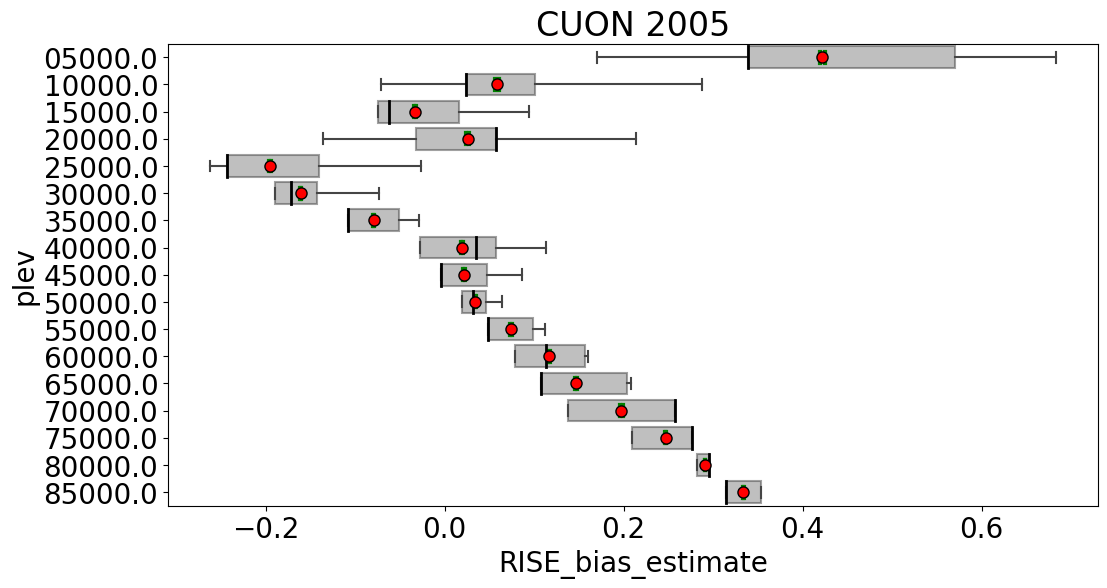

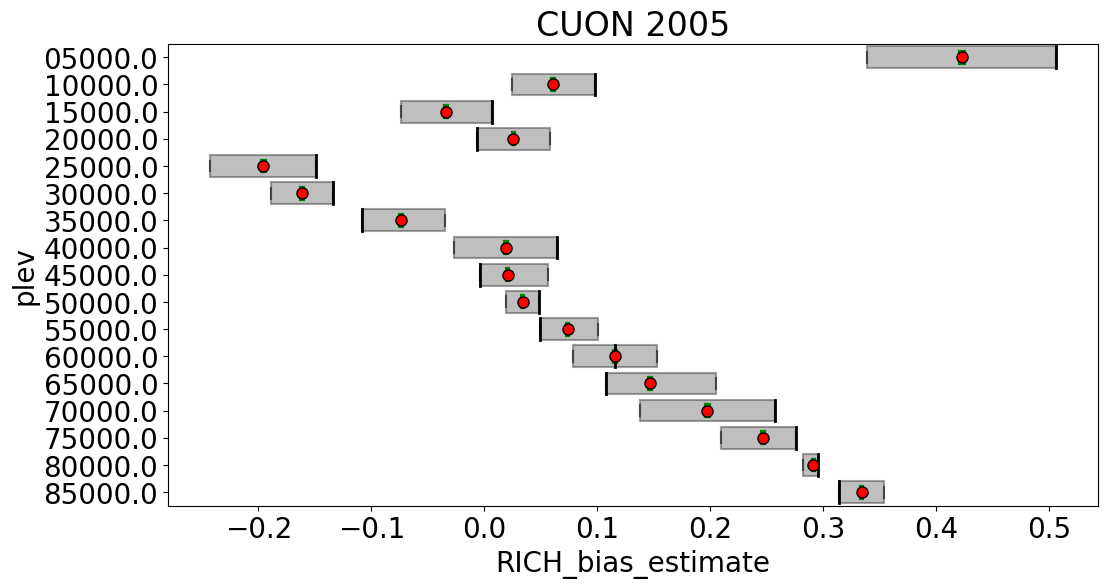

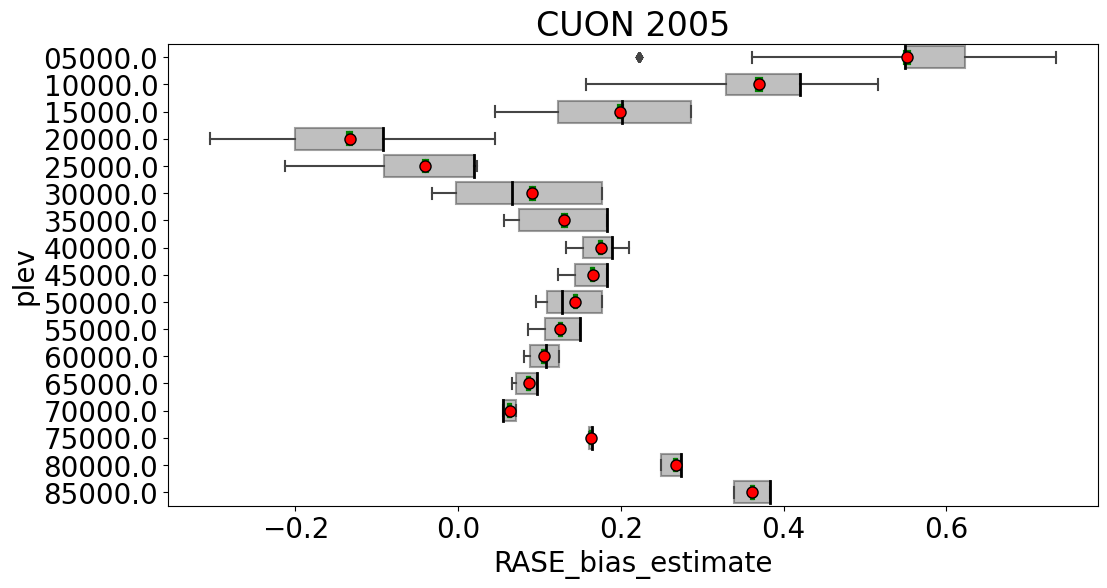

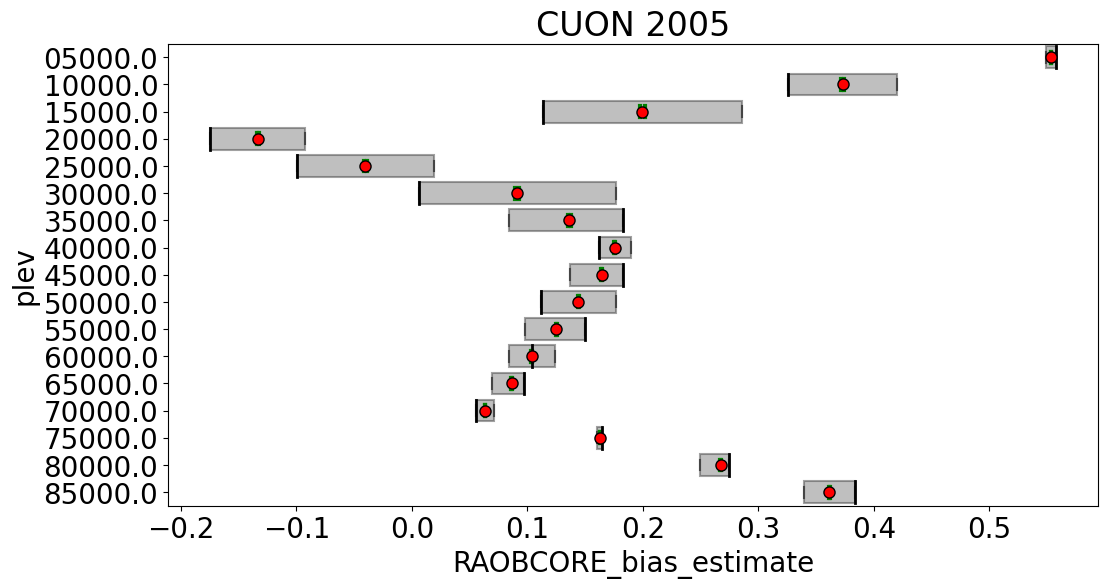

In [9]:
df_in.plev = df_in.plev.str.zfill(7)
df_in = df_in.sort_values(by='plev')

for i in ['RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate',]:
    q3, q1 = np.percentile(df_in[i].dropna(), [75 ,25])
    iqr = q3 - q1
    df_in[i] = df_in[i][np.logical_and(df_in[i] < 3*iqr, df_in[i] > -3*iqr)]

    ax = seaborn.boxplot(
        data=df_in, x=i, y="plev",
        notch=False, showcaps=True, showfliers=True, 
        dodge=False, showmeans=True, 
        boxprops={"facecolor": 'grey', "alpha":0.5},
        medianprops={"color": 'black', "linewidth" : 2},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        whis=3,
        # whis=1.5,
    )
    kwargs = {'alpha':0}
    ax = seaborn.barplot(data=df_in, x=i, y="plev", capsize=.4, n_boot=len(df_in[i]), errorbar=('sd',float(2/np.sqrt(len(df_in[i])))), errwidth=3, errcolor='green', **kwargs)
    ax.set_title('CUON 2005')
    # ax = seaborn.barplot(data=df_in, x=i, y="plev", capsize=.2, n_boot=len(df_in[i]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
    plt.show()
    plt.close()



In [10]:
# rq = {
#     "statid": "11035",
    
#     "date": ["20050101-20051231"],
#     "variable": ["relative_humidity"],# "wind_speed", "geopotential"],
#     "format": "nc",
#     "optional": ['humidity_bias_estimate',],
#     # "dummy": str(np.random.rand()),
# }
# dl = eua.vm_request_wrapper(rq, overwrite=True)# , vm_url="http://127.0.0.1:8007")
# df = dl.to_dataframe()

# df = df[df.plev == 30000]

# hist_data = []
# for i in ['humidity_bias_estimate']:# 'obs_minus_an','obs_minus_bg']:
#     hist_data.append(df[i].dropna())
#     ax = seaborn.histplot(hist_data[-1], label = i, kde=True, bins=70)
# ax.set(xlabel='Adjustments')
# plt.legend() 
# plt.show()

0.024316221747202584


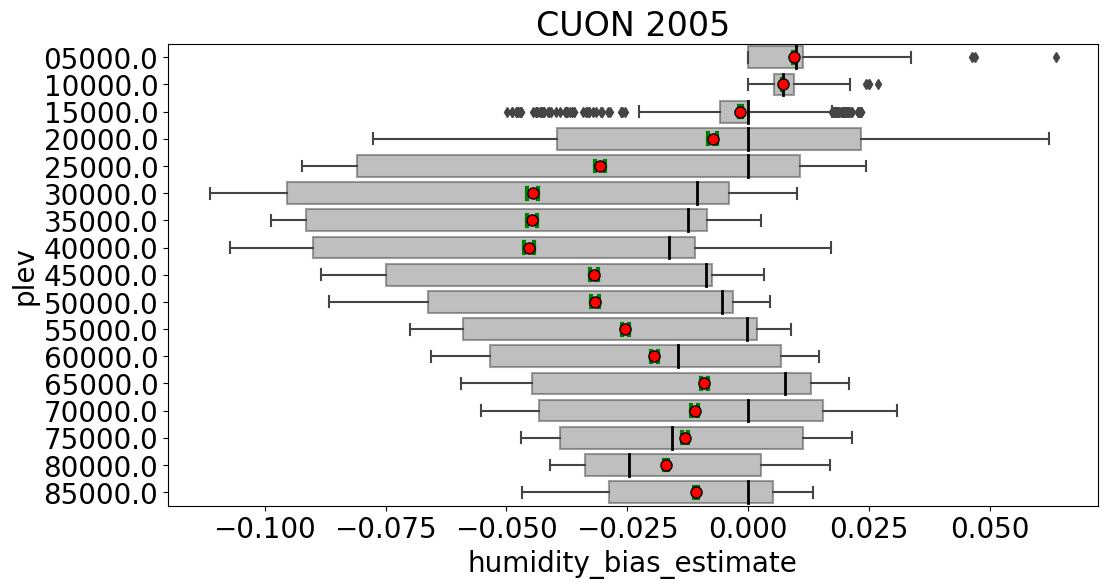

In [11]:
rq = {
    "statid": "11035",
    
    "date": ["20050101-20051231"],
    "variable": ["relative_humidity"],# "wind_speed", "geopotential"],
    "format": "nc",
    "optional": ['humidity_bias_estimate'],
    # "dummy": str(np.random.rand()),
}
df = eua.vm_request_wrapper(rq, overwrite=True)# , vm_url="http://127.0.0.1:8007")
df_all = df.to_dataframe()

df_in = df_all.copy()[df_all.plev.isin(range(5000, 90000,5000))]
df_in['plev'] = df_in['plev'].apply(str)

df_in.plev = df_in.plev.str.zfill(7)
df_in = df_in.sort_values(by='plev')

for i in zip(['humidity_bias_estimate',], ['grey']):
    ax = seaborn.boxplot(
        data=df_in, x=i[0], y="plev",
        notch=False, showcaps=True, showfliers=True, 
        dodge=False,
        boxprops={"facecolor": i[1], "alpha":0.5},
        medianprops={"color": 'black', "linewidth" : 2},
        whis=3,
        # whis=1.5,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
    )
    kwargs = {'alpha':0}
    factor = float(2/np.sqrt(len(df_in[i[0]])))
    print(factor)
    ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.4, n_boot=len(df_in[i[0]]), errorbar=('sd',factor), errwidth=3, errcolor='green', **kwargs)
    ax.set_title('CUON 2005')
    # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)    
    plt.show()
    plt.close()

## Mauritius Data

In [12]:
with eua.CDMDataset(glob.glob("/users/staff/uvoggenberger/scratch/mauritius/*vais*.nc")[0]) as file:
    display(file)
    df_vais = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    df_vais = df_vais[df_vais.observed_variable == 126]
with eua.CDMDataset('/users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc') as file:
    display(file)
    df_meis = file.to_dataframe(groups=['observations_table'], variables=['observation_value', 'observed_variable', 'date_time', 'z_coordinate', 'report_id'])
    df_meis = df_meis[df_meis.observed_variable == 126]


File: <HDF5 file "0-20000-0-61995_mauritius_harvested_vaisala_ascents.csv.nc" (mode r)>
Filesize: 5.95 MB
Filename: /users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_vaisala_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 52
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (56,)
 - V | recordtimestamp______________________________ : : (56,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units_____________________

File: <HDF5 file "0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc" (mode r)>
Filesize: 11.80 MB
Filename: /users/staff/uvoggenberger/scratch/mauritius/0-20000-0-61995_mauritius_harvested_meisei_ascents.csv.nc
(G)roups/(V)ariables: 

 - G | crs__________________________________________ : : 4
 - V | dateindex____________________________________ : : (9,)
 - G | header_table_________________________________ : : 54
 - G | observations_table___________________________ : : 53
 - G | observed_variable____________________________ : : 9
 - V | recordindex__________________________________ : : (250268,)
 - V | recordtimestamp______________________________ : : (250268,)
 - G | sensor_configuration_________________________ : : 0
 - G | source_configuration_________________________ : : 32
 - G | station_configuration________________________ : : 44
 - G | station_configuration_codes__________________ : : 7
 - G | station_type_________________________________ : : 4
 - G | units______________

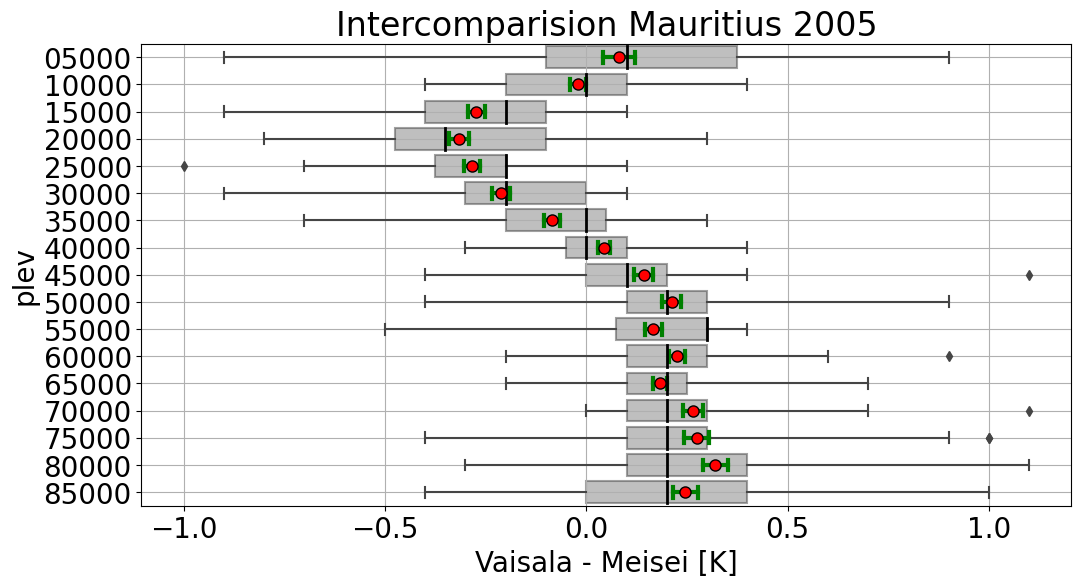

In [13]:
out = {'Difference':[], 'plev': []}
diffs = []
for i in df_vais.date_time.drop_duplicates():
    # print(i.date())
    meis_time = df_meis[df_meis.date_time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].date_time.iloc[0]
        dh = float((i-mt)/ np.timedelta64(1, 'h'))
        if np.logical_and( dh < -3, dh > -5):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_meis[df_meis.report_id == j]
            v_data = df_vais[df_vais.date_time == i]
            for plev in range(5000, 90000,5000):
                diffs.append(v_data[v_data.z_coordinate == find_nearest(v_data.z_coordinate, plev)].iloc[0].observation_value - m_data[m_data.z_coordinate == find_nearest(m_data.z_coordinate, plev)].iloc[0].observation_value)
                out['Difference'].append(diffs[-1])
                out['plev'].append(str(plev))

df_in = pd.DataFrame.from_dict(out)
df_in.plev = df_in.plev.str.zfill(5)
df_in = df_in.sort_values(by="plev")

for i in zip(
    [
        "Difference",
    ],
    ["grey"],
):
    q3, q1 = np.percentile(df_in[i[0]].dropna(), [75 ,25])
    iqr = q3 - q1
    df_in[i[0]] = df_in[i[0]][np.logical_and(df_in[i[0]] < 3*iqr, df_in[i[0]] > -3*iqr)]
    ax = seaborn.boxplot(
        data=df_in,
        x=i[0],
        y="plev",
        notch=False,
        showcaps=True,
        # fliersize = 100,
        showfliers=True,
        dodge=False,
        showmeans=True,
        boxprops={"facecolor": i[1], "alpha": 0.5},
        medianprops={"color": 'black', "linewidth": 2,},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        whis=3,
        # whis=1.5,
    )
    ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
    # ax.set_label(Vaisala - Meisei)
    kwargs = {'alpha':0}
    ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.4, n_boot=len(df_in[i[0]]), errorbar=('sd',float(2/np.sqrt(len(df_in[i[0]])))), errwidth=3, errcolor='green', **kwargs)
    ax.set_title('Intercomparision Mauritius 2005')
    ax.set_xlabel('Vaisala - Meisei [K]')
    # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
    plt.grid()
    plt.show()
    plt.close()

## 47646 as Meisei and 47678 as Vaisala

0    J9H 
Name: sonde_type, dtype: object
0    VN8 
Name: sonde_type, dtype: object


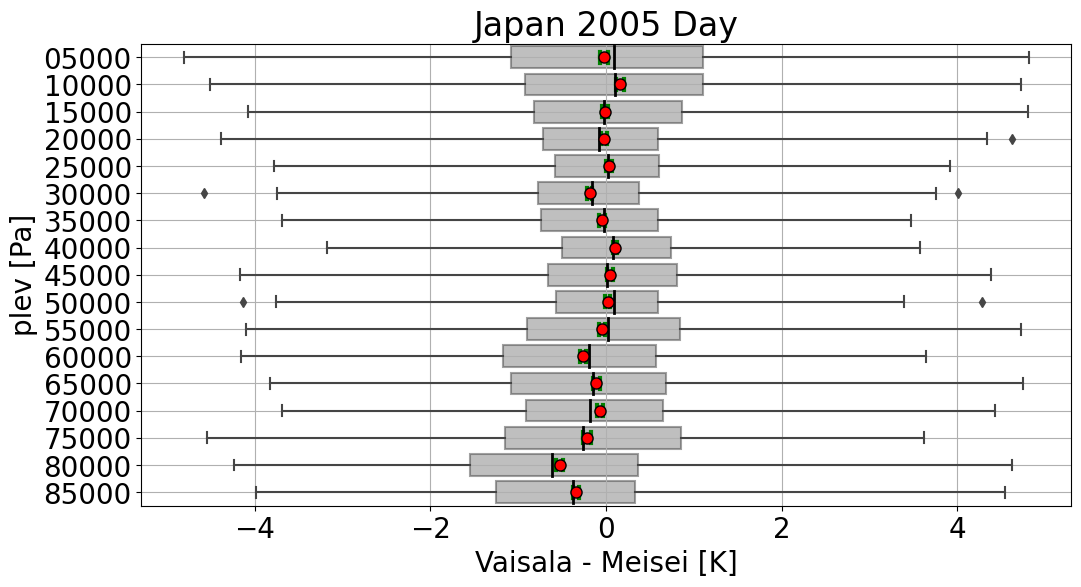

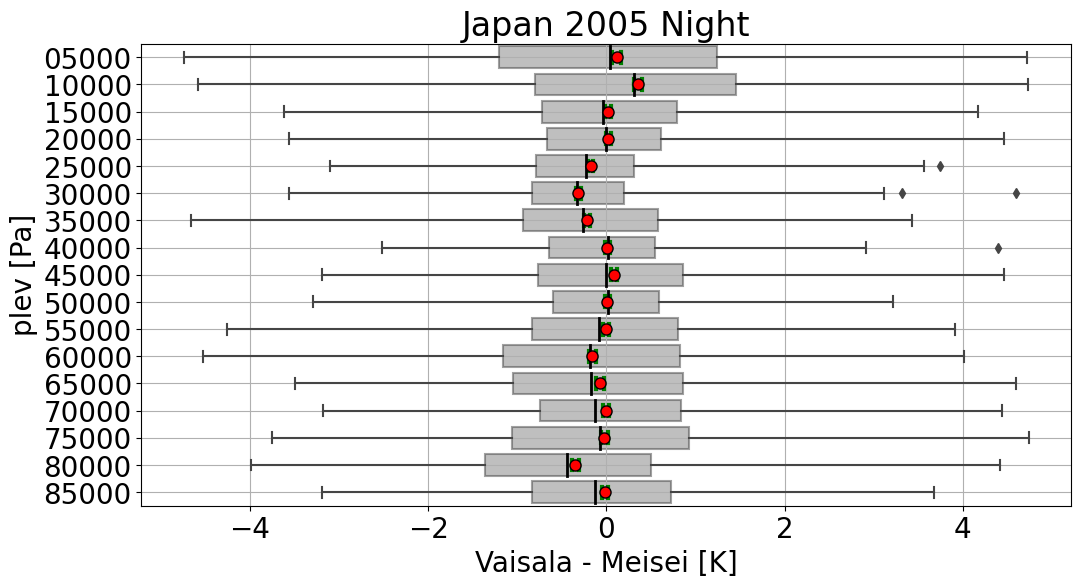

In [20]:
rq = {
    "statid": "47646",
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = dl.to_dataframe()
print(df_tateno.sonde_type.drop_duplicates())

rq = {
    "statid": "47678",
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = dl.to_dataframe()
print(df_compare.sonde_type.drop_duplicates())

out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    # print(i.date())
    meis_time = df_tateno[df_tateno.time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].time.iloc[0]
        dh = float((i - mt) / np.timedelta64(1, "h"))
        if np.logical_and(dh < 1, dh > -1):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_tateno[df_tateno.report_id == j]
            v_data = df_compare[df_compare.time == i]
            for plev in range(5000, 90000, 5000):
                diffs.append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                    - m_data[m_data.plev == find_nearest(m_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                )
                out["time"].append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
                )
                out["Difference"].append(diffs[-1])
                out["plev"].append(str(plev))

for tm in ["Day", "Night"]:
    df_in = pd.DataFrame.from_dict(out)
    if tm == "Day":
        df_in = df_in[np.logical_or(df_in.time.dt.hour > 21, df_in.time.dt.hour <= 9)]
    else:
        df_in = df_in[np.logical_and(df_in.time.dt.hour <= 21, df_in.time.dt.hour > 9)]
    df_in.plev = df_in.plev.str.zfill(5)
    df_in = df_in.sort_values(by="plev")

    for i in zip(
        [
            "Difference",
        ],
        ["grey"],
    ):
        q3, q1 = np.percentile(df_in[i[0]].dropna(), [75, 25])
        iqr = q3 - q1
        df_in[i[0]] = df_in[i[0]][
            np.logical_and(df_in[i[0]] < 3 * iqr, df_in[i[0]] > -3 * iqr)
        ]
        ax = seaborn.boxplot(
            data=df_in,
            x=i[0],
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=True,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": i[1], "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
        kwargs = {'alpha':0}
        ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.4, n_boot=len(df_in[i[0]]), errorbar=('sd',float(2/np.sqrt(len(df_in[i[0]])))), errwidth=3, errcolor='green', **kwargs)
        # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
        ax.set_title('Japan 2005 '+ tm)
        ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
        plt.grid()
        plt.show()
        plt.close()

0    VN8 
Name: sonde_type, dtype: object


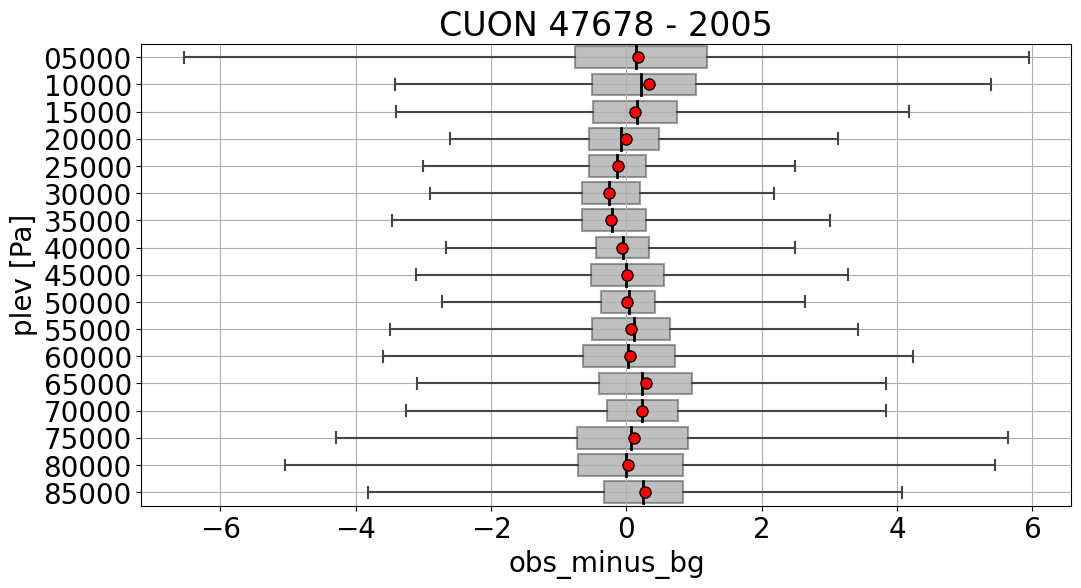

0    VN8 
Name: sonde_type, dtype: object


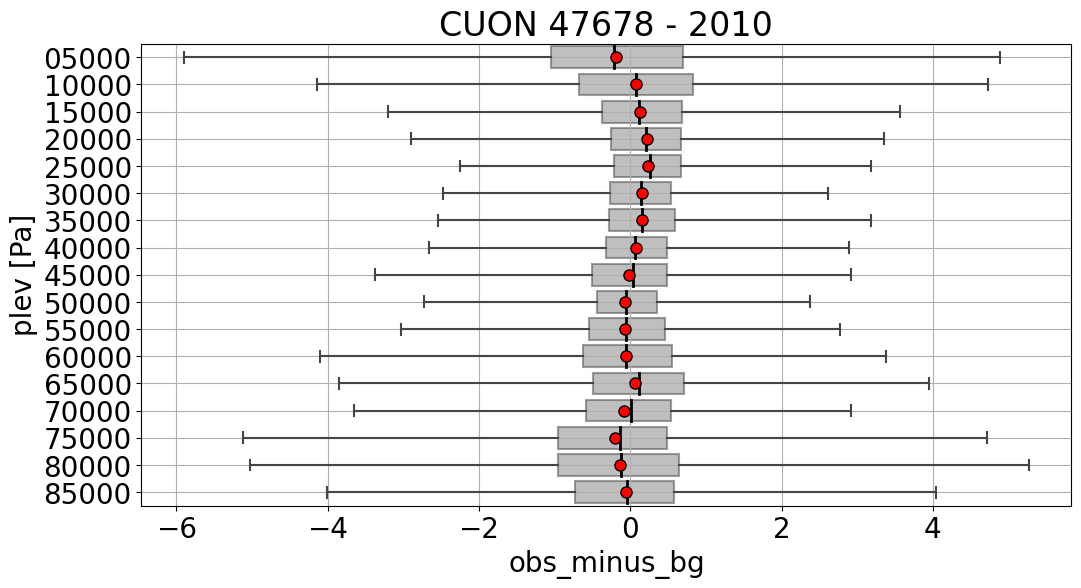

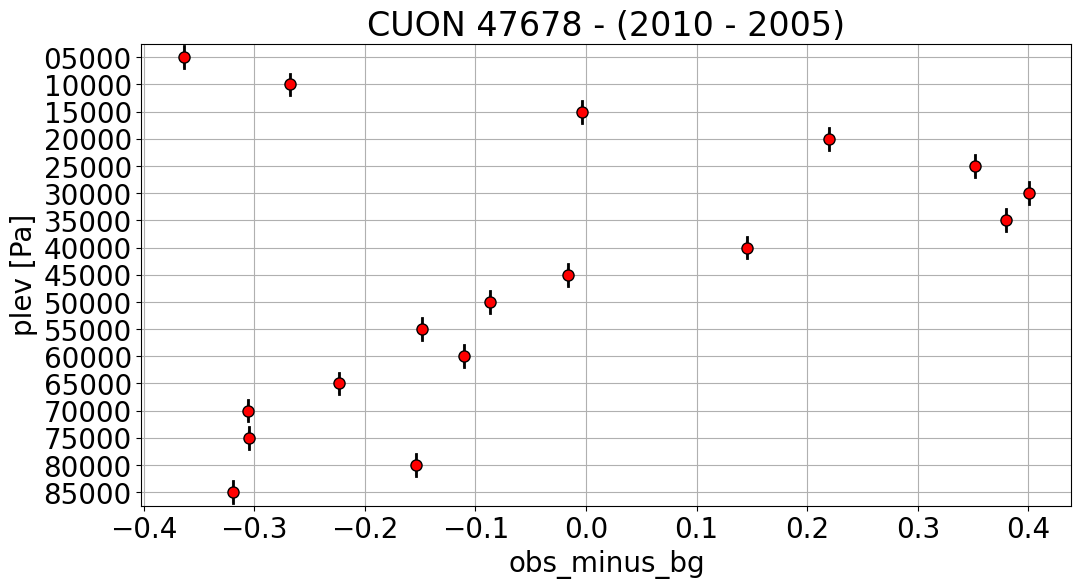

In [15]:
try: del v_data, dl
except: pass

rq = {
    "statid": "47678",
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = dl.to_dataframe()
print(df_tateno.sonde_type.drop_duplicates())




out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_tateno.time.drop_duplicates():
    v_data = df_tateno[df_tateno.time == i]
    for plev in range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2005 = pd.DataFrame.from_dict(out)
df_in_2005.plev = df_in_2005.plev.str.zfill(5)


ax = seaborn.boxplot(
            data=df_in_2005,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47678 - 2005')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

del dl
rq = {
    "statid": "47678",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = dl.to_dataframe()
print(df_compare.sonde_type.drop_duplicates())
out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    v_data = df_compare[df_compare.time == i]
    for plev in range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2010 = pd.DataFrame.from_dict(out)
df_in_2010.plev = df_in_2010.plev.str.zfill(5)


ax = seaborn.boxplot(
            data=df_in_2010,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47678 - 2010')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()



year_diff = df_in_2010.groupby('plev').mean() - df_in_2005.groupby('plev').mean()
ax = seaborn.boxplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47678 - (2010 - 2005)')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

In [63]:
rq = {
    "country": "JPN",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df = dl.to_dataframe()
df

AttributeError: 'CDMDatasetList' object has no attribute 'to_dataframe'

In [64]:
for i in dl:
    display(dl[i].to_dataframe())

,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,45.419998,141.679993,0,-1.521269,1060.0,100000000075612,J9H,0-20000-0-47401,229.899994,2005-01-01 00:00:00
1,45.419998,141.679993,0,1.897217,1190.0,100000000075612,J9H,0-20000-0-47401,233.100006,2005-01-01 00:00:00
2,45.419998,141.679993,0,-3.353404,1480.0,100000000075612,J9H,0-20000-0-47401,228.300003,2005-01-01 00:00:00
3,45.419998,141.679993,0,1.745991,1960.0,100000000075612,J9H,0-20000-0-47401,231.699997,2005-01-01 00:00:00
4,45.419998,141.679993,0,1.425325,2000.0,100000000075612,J9H,0-20000-0-47401,231.300003,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
28149,45.419998,141.679993,0,0.265957,85000.0,100000000076349,J9H,0-20000-0-47401,255.699997,2005-12-31 12:00:00
28150,45.419998,141.679993,0,1.074667,87700.0,100000000076349,J9H,0-20000-0-47401,257.700012,2005-12-31 12:00:00
28151,45.419998,141.679993,0,1.154009,92500.0,100000000076349,J9H,0-20000-0-47401,261.299988,2005-12-31 12:00:00
28152,45.419998,141.679993,0,0.918045,100000.0,100000000076349,J9H,0-20000-0-47401,266.899994,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,43.07,141.330002,0,-4.113113,910.0,100000000074085,J9H,0-20000-0-47412,230.300003,2005-01-01 00:00:00
1,43.07,141.330002,0,-2.413600,1000.0,100000000074085,J9H,0-20000-0-47412,231.100006,2005-01-01 00:00:00
2,43.07,141.330002,0,2.645685,1400.0,100000000074085,J9H,0-20000-0-47412,233.699997,2005-01-01 00:00:00
3,43.07,141.330002,0,-1.891982,2000.0,100000000074085,J9H,0-20000-0-47412,227.500000,2005-01-01 00:00:00
4,43.07,141.330002,0,-3.923675,2350.0,100000000074085,J9H,0-20000-0-47412,225.500000,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
28706,43.07,141.330002,0,0.196368,85000.0,100000000074820,J9H,0-20000-0-47412,257.899994,2005-12-31 12:00:00
28707,43.07,141.330002,0,1.559598,92500.0,100000000074820,J9H,0-20000-0-47412,263.700012,2005-12-31 12:00:00
28708,43.07,141.330002,0,2.094895,100000.0,100000000074820,J9H,0-20000-0-47412,269.100006,2005-12-31 12:00:00
28709,43.07,141.330002,0,2.074889,100900.0,100000000074820,J9H,0-20000-0-47412,269.700012,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,43.330002,145.580002,0,-2.060108,1240.0,100000000070888,J9H,0-20000-0-47420,229.699997,2005-01-01 00:00:00
1,43.330002,145.580002,0,-0.051171,2000.0,100000000070888,J9H,0-20000-0-47420,228.699997,2005-01-01 00:00:00
2,43.330002,145.580002,0,2.149151,2460.0,100000000070888,J9H,0-20000-0-47420,229.300003,2005-01-01 00:00:00
3,43.330002,145.580002,0,0.665748,3000.0,100000000070888,J9H,0-20000-0-47420,227.699997,2005-01-01 00:00:00
4,43.330002,145.580002,0,-2.371164,3520.0,100000000070888,J9H,0-20000-0-47420,225.699997,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
28808,43.330002,145.580002,0,-0.237636,85000.0,100000000072355,J9H,0-20000-0-47420,255.899994,2005-12-31 12:00:00
28809,43.330002,145.580002,0,-0.114112,92500.0,100000000072355,J9H,0-20000-0-47420,261.700012,2005-12-31 12:00:00
28810,43.330002,145.580002,0,0.025357,95600.0,100000000072355,J9H,0-20000-0-47420,263.899994,2005-12-31 12:00:00
28811,43.330002,145.580002,0,-0.013467,100000.0,100000000072355,J9H,0-20000-0-47420,267.100006,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,37.400002,136.899994,0,-0.005499,2810.0,100000000074948,J9H,0-20000-0-47600,225.500000,2005-01-01 00:00:00
1,37.400002,136.899994,0,-1.423347,3000.0,100000000074948,J9H,0-20000-0-47600,224.100006,2005-01-01 00:00:00
2,37.400002,136.899994,0,-3.515918,4290.0,100000000074948,J9H,0-20000-0-47600,222.699997,2005-01-01 00:00:00
3,37.400002,136.899994,0,2.495138,5000.0,100000000074948,J9H,0-20000-0-47600,228.500000,2005-01-01 00:00:00
4,37.400002,136.899994,0,5.752107,5260.0,100000000074948,J9H,0-20000-0-47600,230.500000,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
30285,37.400002,136.899994,0,-0.035319,85000.0,100000000075693,J9H,0-20000-0-47600,263.100006,2005-12-31 12:00:00
30286,37.400002,136.899994,0,0.493087,92500.0,100000000075693,J9H,0-20000-0-47600,268.299988,2005-12-31 12:00:00
30287,37.400002,136.899994,0,-0.135294,100000.0,100000000075693,J9H,0-20000-0-47600,273.600006,2005-12-31 12:00:00
30288,37.400002,136.899994,0,-0.175816,100300.0,100000000075693,J9H,0-20000-0-47600,273.799988,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,36.049999,140.130005,0,0.122979,720.0,100000000130638,J9H,0-20000-0-47646,237.899994,2005-01-01 00:00:00
1,36.049999,140.130005,0,5.538611,860.0,100000000130638,J9H,0-20000-0-47646,240.699997,2005-01-01 00:00:00
2,36.049999,140.130005,0,2.859902,1000.0,100000000130638,J9H,0-20000-0-47646,235.899994,2005-01-01 00:00:00
3,36.049999,140.130005,0,-0.882960,1180.0,100000000130638,J9H,0-20000-0-47646,230.699997,2005-01-01 00:00:00
4,36.049999,140.130005,0,-1.278903,1460.0,100000000130638,J9H,0-20000-0-47646,228.100006,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
30813,36.049999,140.130005,0,-1.094782,85000.0,100000000131378,J9H,0-20000-0-47646,265.100006,2005-12-31 12:00:00
30814,36.049999,140.130005,0,-0.171959,92500.0,100000000131378,J9H,0-20000-0-47646,270.700012,2005-12-31 12:00:00
30815,36.049999,140.130005,0,0.173930,96900.0,100000000131378,J9H,0-20000-0-47646,273.799988,2005-12-31 12:00:00
30816,36.049999,140.130005,0,-0.496255,100000.0,100000000131378,J9H,0-20000-0-47646,274.000000,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,33.119999,139.779999,0,0.264468,620.0,100000000057331,VN8,0-20000-0-47678,241.100006,2005-01-01 01:00:00
1,33.119999,139.779999,0,2.885184,710.0,100000000057331,VN8,0-20000-0-47678,242.300003,2005-01-01 01:00:00
2,33.119999,139.779999,0,1.346347,1000.0,100000000057331,VN8,0-20000-0-47678,234.899994,2005-01-01 01:00:00
3,33.119999,139.779999,0,-1.289672,1260.0,100000000057331,VN8,0-20000-0-47678,228.699997,2005-01-01 01:00:00
4,33.119999,139.779999,0,1.969090,1390.0,100000000057331,VN8,0-20000-0-47678,231.100006,2005-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...
39044,33.119999,139.779999,865410962,1.744057,92100.0,100000000058127,VN8,0-20000-0-47678,277.399994,2005-12-31 12:00:00
39045,33.119999,139.779999,-57508516,1.419318,92500.0,100000000058127,VN8,0-20000-0-47678,277.399994,2005-12-31 12:00:00
39046,33.119999,139.779999,-1080904016,0.475101,92900.0,100000000058127,VN8,0-20000-0-47678,276.799988,2005-12-31 12:00:00
39047,33.119999,139.779999,-1068088315,0.112912,100000.0,100000000058127,VN8,0-20000-0-47678,282.399994,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,35.43,133.330002,0,-2.107412,1330.0,100000000070125,VN8,0-20000-0-47741,226.899994,2005-01-01 00:00:00
1,35.43,133.330002,0,0.744867,1830.0,100000000070125,VN8,0-20000-0-47741,227.699997,2005-01-01 00:00:00
2,35.43,133.330002,0,-1.526268,2000.0,100000000070125,VN8,0-20000-0-47741,224.500000,2005-01-01 00:00:00
3,35.43,133.330002,0,-3.686398,2110.0,100000000070125,VN8,0-20000-0-47741,221.899994,2005-01-01 00:00:00
4,35.43,133.330002,0,-3.695581,2520.0,100000000070125,VN8,0-20000-0-47741,221.300003,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
30453,35.43,133.330002,0,-3.139996,84200.0,100000000070865,VN8,0-20000-0-47741,263.899994,2005-12-31 12:00:00
30454,35.43,133.330002,0,-2.704303,85000.0,100000000070865,VN8,0-20000-0-47741,264.299988,2005-12-31 12:00:00
30455,35.43,133.330002,0,-0.368593,92500.0,100000000070865,VN8,0-20000-0-47741,270.100006,2005-12-31 12:00:00
30456,35.43,133.330002,0,-0.860385,100000.0,100000000070865,VN8,0-20000-0-47741,275.399994,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,33.580002,130.380005,0,-0.517237,790.0,100000000118125,J9H,0-20000-0-47807,235.100006,2005-01-01 00:00:00
1,33.580002,130.380005,0,2.415500,1000.0,100000000118125,J9H,0-20000-0-47807,234.500000,2005-01-01 00:00:00
2,33.580002,130.380005,0,-0.899134,1380.0,100000000118125,J9H,0-20000-0-47807,226.899994,2005-01-01 00:00:00
3,33.580002,130.380005,0,-0.079550,2000.0,100000000118125,J9H,0-20000-0-47807,225.500000,2005-01-01 00:00:00
4,33.580002,130.380005,0,-0.085902,2810.0,100000000118125,J9H,0-20000-0-47807,222.500000,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
30737,33.580002,130.380005,0,-0.328111,85000.0,100000000118864,J9H,0-20000-0-47807,270.899994,2005-12-31 12:00:00
30738,33.580002,130.380005,0,-2.559700,87500.0,100000000118864,J9H,0-20000-0-47807,269.700012,2005-12-31 12:00:00
30739,33.580002,130.380005,0,-1.336661,92500.0,100000000118864,J9H,0-20000-0-47807,272.899994,2005-12-31 12:00:00
30740,33.580002,130.380005,0,-0.448027,100000.0,100000000118864,J9H,0-20000-0-47807,278.200012,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,31.549999,130.550003,0,-0.236833,760.0,100000000078080,J9H,0-20000-0-47827,234.899994,2005-01-01 00:00:00
1,31.549999,130.550003,0,2.052809,1000.0,100000000078080,J9H,0-20000-0-47827,232.300003,2005-01-01 00:00:00
2,31.549999,130.550003,0,-2.016003,1830.0,100000000078080,J9H,0-20000-0-47827,222.699997,2005-01-01 00:00:00
3,31.549999,130.550003,0,0.054089,2000.0,100000000078080,J9H,0-20000-0-47827,223.899994,2005-01-01 00:00:00
4,31.549999,130.550003,0,0.197378,3000.0,100000000078080,J9H,0-20000-0-47827,221.300003,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
30811,31.549999,130.550003,0,0.062564,73800.0,100000000078820,J9H,0-20000-0-47827,271.899994,2005-12-31 12:00:00
30812,31.549999,130.550003,0,1.856715,85000.0,100000000078820,J9H,0-20000-0-47827,277.600006,2005-12-31 12:00:00
30813,31.549999,130.550003,0,-0.853322,92500.0,100000000078820,J9H,0-20000-0-47827,279.399994,2005-12-31 12:00:00
30814,31.549999,130.550003,0,1.763756,100000.0,100000000078820,J9H,0-20000-0-47827,282.600006,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,24.33,124.169998,0,-0.132030,830.0,100000000055743,J9H,0-20000-0-47918,233.100006,2005-01-01 00:00:00
1,24.33,124.169998,0,0.849943,1000.0,100000000055743,J9H,0-20000-0-47918,230.699997,2005-01-01 00:00:00
2,24.33,124.169998,0,1.403521,2000.0,100000000055743,J9H,0-20000-0-47918,223.500000,2005-01-01 00:00:00
3,24.33,124.169998,0,1.779983,2110.0,100000000055743,J9H,0-20000-0-47918,223.300003,2005-01-01 00:00:00
4,24.33,124.169998,0,-2.427690,2520.0,100000000055743,J9H,0-20000-0-47918,217.899994,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
30384,24.33,124.169998,502,-0.193543,87600.0,100000000056491,J9H,0-20000-0-47918,288.799988,2005-12-31 12:00:00
30385,24.33,124.169998,2080374784,-1.946233,89700.0,100000000056491,J9H,0-20000-0-47918,288.000000,2005-12-31 12:00:00
30386,24.33,124.169998,12,-1.619842,92500.0,100000000056491,J9H,0-20000-0-47918,289.200012,2005-12-31 12:00:00
30387,24.33,124.169998,905969664,0.876482,100000.0,100000000056491,J9H,0-20000-0-47918,294.399994,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,25.83,131.229996,0,-1.371566,1020.0,100000000059262,J9H,0-20000-0-47945,228.100006,2005-01-01 00:00:00
1,25.83,131.229996,0,3.898891,1580.0,100000000059262,J9H,0-20000-0-47945,229.699997,2005-01-01 00:00:00
2,25.83,131.229996,0,0.741323,2000.0,100000000059262,J9H,0-20000-0-47945,224.500000,2005-01-01 00:00:00
3,25.83,131.229996,0,0.460685,3000.0,100000000059262,J9H,0-20000-0-47945,218.100006,2005-01-01 00:00:00
4,25.83,131.229996,0,-1.174848,5000.0,100000000059262,J9H,0-20000-0-47945,209.899994,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
37880,25.83,131.229996,39,-0.025325,85000.0,100000000060055,VN8,0-20000-0-47945,282.399994,2005-12-31 12:00:00
37881,25.83,131.229996,0,-0.323870,92500.0,100000000060055,VN8,0-20000-0-47945,285.600006,2005-12-31 12:00:00
37882,25.83,131.229996,7098,-1.624846,96100.0,100000000060055,VN8,0-20000-0-47945,286.600006,2005-12-31 12:00:00
37883,25.83,131.229996,0,-2.245523,100000.0,100000000060055,VN8,0-20000-0-47945,289.200012,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,27.1,142.179993,0,2.212455,730.0,100000000031025,ZPg,0-20000-0-47971,237.300003,2005-01-01 00:00:00
1,27.1,142.179993,0,-1.022773,1000.0,100000000031025,ZPg,0-20000-0-47971,232.500000,2005-01-01 00:00:00
2,27.1,142.179993,0,-2.480170,2000.0,100000000031025,ZPg,0-20000-0-47971,222.300003,2005-01-01 00:00:00
3,27.1,142.179993,0,1.694936,2760.0,100000000031025,ZPg,0-20000-0-47971,222.500000,2005-01-01 00:00:00
4,27.1,142.179993,0,0.729253,3000.0,100000000031025,ZPg,0-20000-0-47971,219.899994,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
30821,27.1,142.179993,0,0.534293,85000.0,100000000031782,ZPg,0-20000-0-47971,279.399994,2005-12-31 12:00:00
30822,27.1,142.179993,0,0.432317,85200.0,100000000031782,ZPg,0-20000-0-47971,279.399994,2005-12-31 12:00:00
30823,27.1,142.179993,0,1.156192,92500.0,100000000031782,ZPg,0-20000-0-47971,284.200012,2005-12-31 12:00:00
30824,27.1,142.179993,0,1.174021,100000.0,100000000031782,ZPg,0-20000-0-47971,289.799988,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,24.280001,153.979996,0,2.755837,690.0,100000000044763,J01,0-20000-0-47991,238.100006,2005-01-01 00:00:00
1,24.280001,153.979996,0,1.908217,1000.0,100000000044763,J01,0-20000-0-47991,231.300003,2005-01-01 00:00:00
2,24.280001,153.979996,0,0.025575,1090.0,100000000044763,J01,0-20000-0-47991,228.699997,2005-01-01 00:00:00
3,24.280001,153.979996,0,0.900720,1740.0,100000000044763,J01,0-20000-0-47991,228.500000,2005-01-01 00:00:00
4,24.280001,153.979996,0,-0.071979,2000.0,100000000044763,J01,0-20000-0-47991,225.100006,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
28537,24.280001,153.979996,0,2.495792,85000.0,100000000045493,J01,0-20000-0-47991,284.399994,2005-12-31 12:00:00
28538,24.280001,153.979996,0,-0.821392,88200.0,100000000045493,J01,0-20000-0-47991,283.200012,2005-12-31 12:00:00
28539,24.280001,153.979996,0,0.477200,92500.0,100000000045493,J01,0-20000-0-47991,287.000000,2005-12-31 12:00:00
28540,24.280001,153.979996,0,0.042996,100000.0,100000000045493,J01,0-20000-0-47991,293.000000,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,-69.0,39.580002,0,-0.419669,940.0,100000000039408,J9H,0-20000-0-89532,246.500000,2005-01-01 00:00:00
1,-69.0,39.580002,0,-0.455285,2000.0,100000000039408,J9H,0-20000-0-89532,238.699997,2005-01-01 00:00:00
2,-69.0,39.580002,0,-0.761105,2120.0,100000000039408,J9H,0-20000-0-89532,237.899994,2005-01-01 00:00:00
3,-69.0,39.580002,0,0.022958,3000.0,100000000039408,J9H,0-20000-0-89532,236.300003,2005-01-01 00:00:00
4,-69.0,39.580002,0,0.266942,5000.0,100000000039408,J9H,0-20000-0-89532,234.300003,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
21594,-69.0,39.580002,0,0.985239,89400.0,100000000040102,J9H,0-20000-0-89532,266.700012,2005-12-31 12:00:00
21595,-69.0,39.580002,0,-1.912825,92500.0,100000000040102,J9H,0-20000-0-89532,266.500000,2005-12-31 12:00:00
21596,-69.0,39.580002,0,-2.078166,92700.0,100000000040102,J9H,0-20000-0-89532,266.500000,2005-12-31 12:00:00
21597,-69.0,39.580002,0,-0.905088,97600.0,100000000040102,J9H,0-20000-0-89532,271.100006,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,42.98,144.380005,0,40.079376,900.0,100000000000001,VN8,0-20001-0-47418,269.700012,2010-03-15 00:00:00
1,42.98,144.380005,0,0.067896,1440.0,100000000000001,VN8,0-20001-0-47418,228.100006,2010-03-15 00:00:00
2,42.98,144.380005,0,0.757527,2000.0,100000000000001,VN8,0-20001-0-47418,224.699997,2010-03-15 00:00:00
3,42.98,144.380005,0,-0.991389,2260.0,100000000000001,VN8,0-20001-0-47418,221.699997,2010-03-15 00:00:00
4,42.98,144.380005,0,44.908451,2300.0,100000000000001,VN8,0-20001-0-47418,267.500000,2010-03-15 00:00:00
...,...,...,...,...,...,...,...,...,...,...
27720,42.98,144.380005,0,-0.228015,75600.0,100000000000611,VN8,0-20001-0-47418,257.500000,2010-12-31 12:00:00
27721,42.98,144.380005,0,0.176099,85000.0,100000000000611,VN8,0-20001-0-47418,263.899994,2010-12-31 12:00:00
27722,42.98,144.380005,0,0.271498,89800.0,100000000000611,VN8,0-20001-0-47418,266.700012,2010-12-31 12:00:00
27723,42.98,144.380005,0,0.776001,92500.0,100000000000611,VN8,0-20001-0-47418,268.700012,2010-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,39.720001,140.100006,0,0.376205,760.0,100000000075037,J9H,0-20001-0-47582,235.500000,2005-01-01 00:00:00
1,39.720001,140.100006,0,1.553166,970.0,100000000075037,J9H,0-20001-0-47582,234.500000,2005-01-01 00:00:00
2,39.720001,140.100006,0,0.569907,1000.0,100000000075037,J9H,0-20001-0-47582,233.500000,2005-01-01 00:00:00
3,39.720001,140.100006,0,-3.002954,1130.0,100000000075037,J9H,0-20001-0-47582,230.100006,2005-01-01 00:00:00
4,39.720001,140.100006,0,-0.792291,1230.0,100000000075037,J9H,0-20001-0-47582,232.300003,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
29749,39.720001,140.100006,0,1.601712,85000.0,100000000075776,J9H,0-20001-0-47582,261.700012,2005-12-31 12:00:00
29750,39.720001,140.100006,0,0.912299,90700.0,100000000075776,J9H,0-20001-0-47582,264.500000,2005-12-31 12:00:00
29751,39.720001,140.100006,0,0.832092,92500.0,100000000075776,J9H,0-20001-0-47582,265.700012,2005-12-31 12:00:00
29752,39.720001,140.100006,0,0.637751,100000.0,100000000075776,J9H,0-20001-0-47582,271.299988,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,33.450001,135.770004,0,-2.127187,860.0,100000000073344,J9H,0-20001-0-47778,234.100006,2005-01-01 00:00:00
1,33.450001,135.770004,0,-4.157102,990.0,100000000073344,J9H,0-20001-0-47778,230.699997,2005-01-01 00:00:00
2,33.450001,135.770004,0,-3.869864,1000.0,100000000073344,J9H,0-20001-0-47778,230.899994,2005-01-01 00:00:00
3,33.450001,135.770004,0,2.293969,1220.0,100000000073344,J9H,0-20001-0-47778,234.300003,2005-01-01 00:00:00
4,33.450001,135.770004,0,-1.529574,1620.0,100000000073344,J9H,0-20001-0-47778,225.100006,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
30640,33.450001,135.750000,0,2.777045,86100.0,100000000074094,J9H,0-20001-0-47778,272.500000,2005-12-31 12:00:00
30641,33.450001,135.750000,0,1.919843,87300.0,100000000074094,J9H,0-20001-0-47778,272.299988,2005-12-31 12:00:00
30642,33.450001,135.750000,0,-0.078611,92500.0,100000000074094,J9H,0-20001-0-47778,274.399994,2005-12-31 12:00:00
30643,33.450001,135.750000,0,-1.062216,100000.0,100000000074094,J9H,0-20001-0-47778,279.399994,2005-12-31 12:00:00


,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,28.4,129.550003,0,-1.382069,870.0,100000000062629,J9H,0-20001-0-47909,231.100006,2005-01-01 00:00:00
1,28.4,129.550003,0,1.393656,1000.0,100000000062629,J9H,0-20001-0-47909,230.899994,2005-01-01 00:00:00
2,28.4,129.550003,0,2.366291,1220.0,100000000062629,J9H,0-20001-0-47909,230.300003,2005-01-01 00:00:00
3,28.4,129.550003,0,-0.134697,2000.0,100000000062629,J9H,0-20001-0-47909,223.899994,2005-01-01 00:00:00
4,28.4,129.550003,0,-1.360188,2240.0,100000000062629,J9H,0-20001-0-47909,220.899994,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
29852,28.4,129.550003,-94266357,1.089554,69200.0,100000000063373,J9H,0-20001-0-47909,273.799988,2005-12-31 12:00:00
29853,28.4,129.550003,-1386382454,1.053589,70000.0,100000000063373,J9H,0-20001-0-47909,274.200012,2005-12-31 12:00:00
29854,28.4,129.550003,1552712928,-0.486044,85000.0,100000000063373,J9H,0-20001-0-47909,281.200012,2005-12-31 12:00:00
29855,28.4,129.550003,-494978746,-0.717948,92500.0,100000000063373,J9H,0-20001-0-47909,284.399994,2005-12-31 12:00:00


In [62]:
rq = {
    "statid": "47991",
    "date": ["20050101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df = dl.to_dataframe()
df

,lat,lon,obs,obs_minus_bg,plev,report_id,sonde_type,station_id,ta,time
0,24.280001,153.979996,0,2.755837,690.0,100000000044763,J01,0-20000-0-47991,238.100006,2005-01-01 00:00:00
1,24.280001,153.979996,0,1.908217,1000.0,100000000044763,J01,0-20000-0-47991,231.300003,2005-01-01 00:00:00
2,24.280001,153.979996,0,0.025575,1090.0,100000000044763,J01,0-20000-0-47991,228.699997,2005-01-01 00:00:00
3,24.280001,153.979996,0,0.900720,1740.0,100000000044763,J01,0-20000-0-47991,228.500000,2005-01-01 00:00:00
4,24.280001,153.979996,0,-0.071979,2000.0,100000000044763,J01,0-20000-0-47991,225.100006,2005-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
28537,24.280001,153.979996,0,2.495792,85000.0,100000000045493,J01,0-20000-0-47991,284.399994,2005-12-31 12:00:00
28538,24.280001,153.979996,0,-0.821392,88200.0,100000000045493,J01,0-20000-0-47991,283.200012,2005-12-31 12:00:00
28539,24.280001,153.979996,0,0.477200,92500.0,100000000045493,J01,0-20000-0-47991,287.000000,2005-12-31 12:00:00
28540,24.280001,153.979996,0,0.042996,100000.0,100000000045493,J01,0-20000-0-47991,293.000000,2005-12-31 12:00:00


0    J01 
Name: sonde_type, dtype: object


,Difference,plev,time
0,-0.270705,05000,2005-01-01
1,0.111098,10000,2005-01-01
2,1.539837,15000,2005-01-01
3,0.371781,20000,2005-01-01
4,-0.073119,25000,2005-01-01


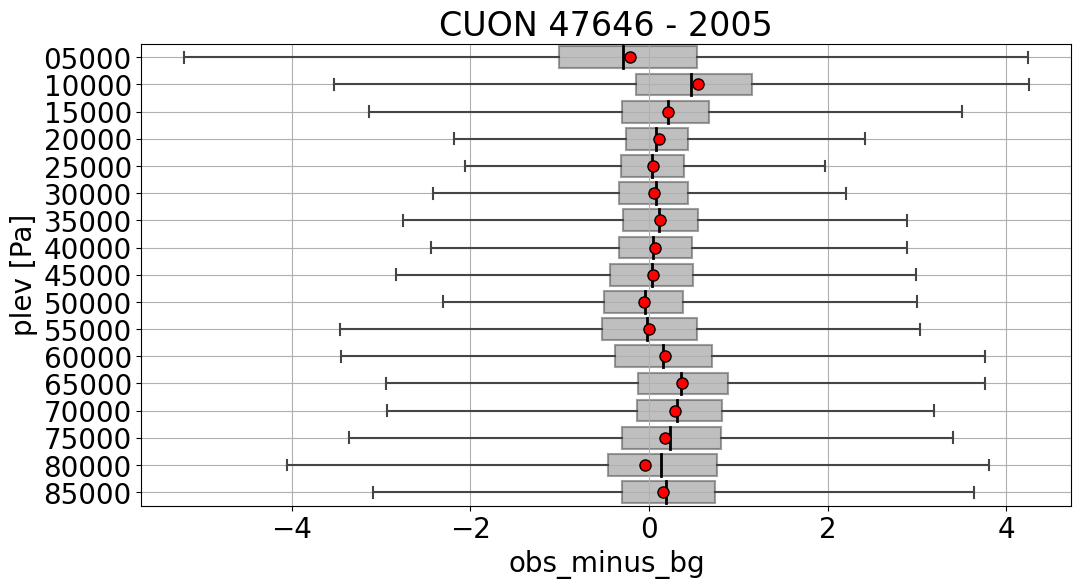

In [6]:
try:
    del dl
    del v_data
    del df_in
except:
    pass
rq = {
    "statid": "47991",
    "date": ["20050101-20051231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = dl.to_dataframe()
print(df_tateno.sonde_type.drop_duplicates())




out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_tateno.time.drop_duplicates():
    v_data = df_tateno[df_tateno.time == i]
    for plev in range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2005 = pd.DataFrame.from_dict(out)
df_in_2005.plev = df_in_2005.plev.str.zfill(5)
display(df_in_2005.head())


ax = seaborn.boxplot(
            data=df_in_2005,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47646 - 2005')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()
    
####



0    J01 
Name: sonde_type, dtype: object


,Difference,plev,time
0,-0.450036,05000,2010-01-01
1,0.038060,10000,2010-01-01
2,-0.621772,15000,2010-01-01
3,0.619840,20000,2010-01-01
4,1.061988,25000,2010-01-01


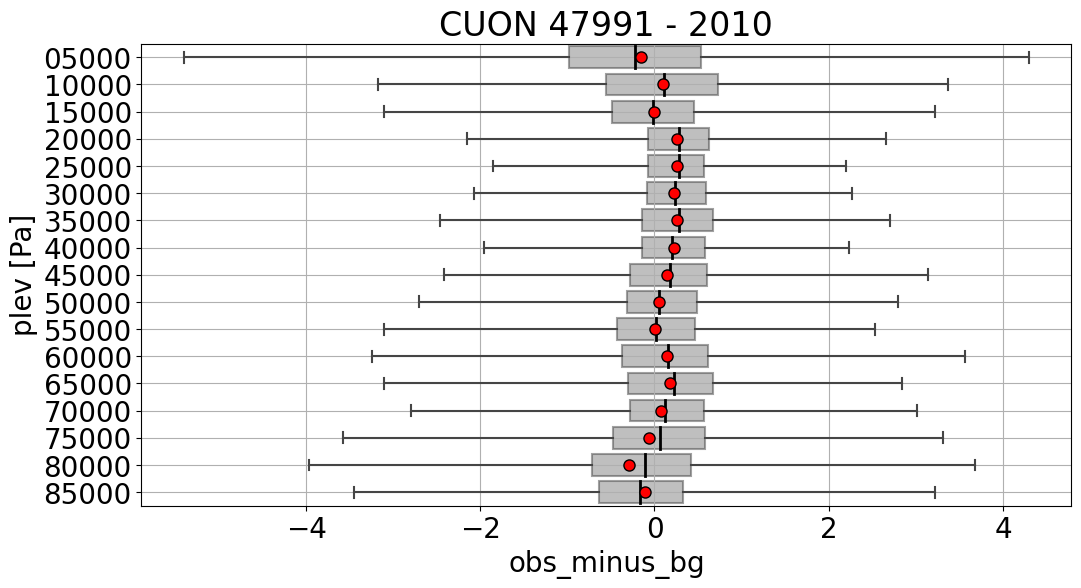

/tmp/ipykernel_3832404/2901527304.py:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_diff = df_in_2010.groupby('plev').mean() - df_in_2005.groupby('plev').mean()
/tmp/ipykernel_3832404/2901527304.py:61: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_diff = df_in_2010.groupby('plev').mean() - df_in_2005.groupby('plev').mean()


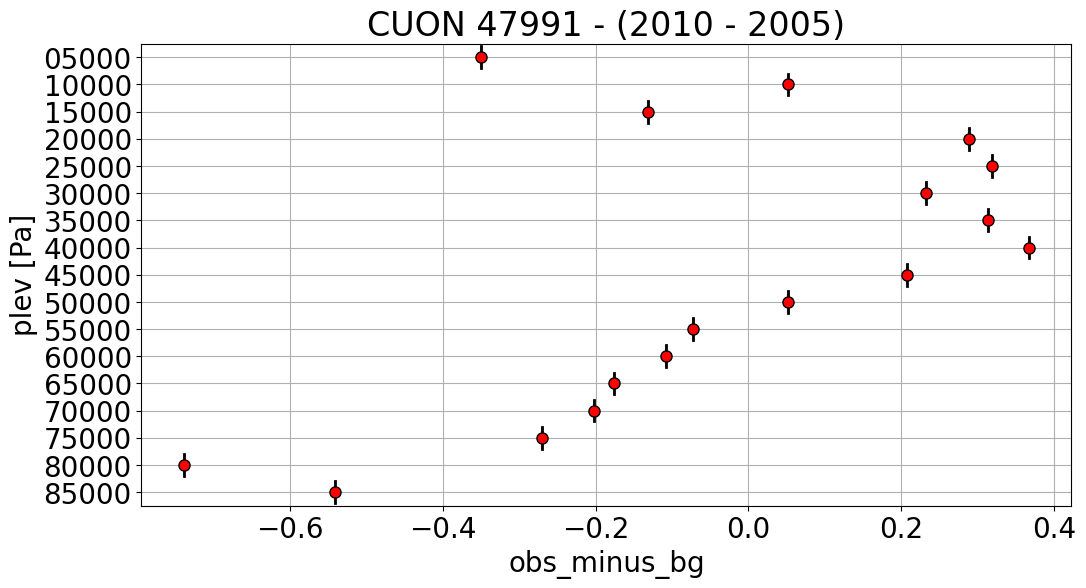

In [11]:
rq = {
    "statid": "47991",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl_2 = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = dl_2.to_dataframe()
print(df_compare.sonde_type.drop_duplicates())
out_2 = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    v_data_2 = df_compare[df_compare.time == i]
    for plev in range(5000, 90000, 5000):
        diffs.append(
            v_data_2[v_data_2.plev == find_nearest(v_data_2.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out_2["time"].append(
            v_data_2[v_data_2.plev == find_nearest(v_data_2.plev, plev)].iloc[0].time
        )
        out_2["Difference"].append(diffs[-1])
        out_2["plev"].append(str(plev))

df_in_2010 = pd.DataFrame.from_dict(out_2)
df_in_2010.plev = df_in_2010.plev.str.zfill(5)
display(df_in_2010.head())

ax = seaborn.boxplot(
            data=df_in_2010,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47991 - 2010')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

year_diff = df_in_2010.groupby('plev').mean() - df_in_2005.groupby('plev').mean()
ax = seaborn.boxplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47991 - (2010 - 2005)')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

0    J9H 
Name: sonde_type, dtype: object


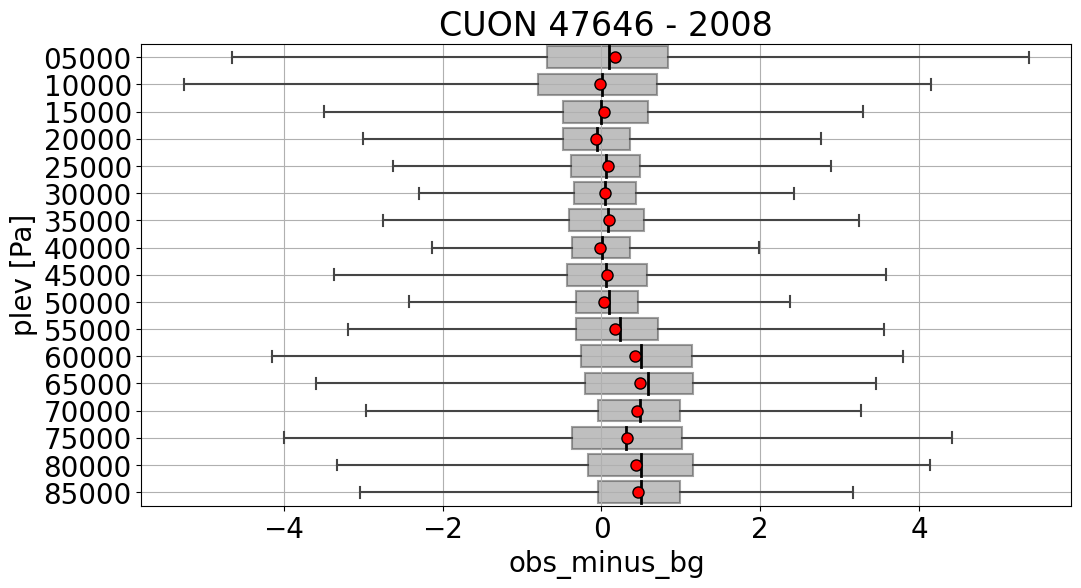

0    J9H 
Name: sonde_type, dtype: object


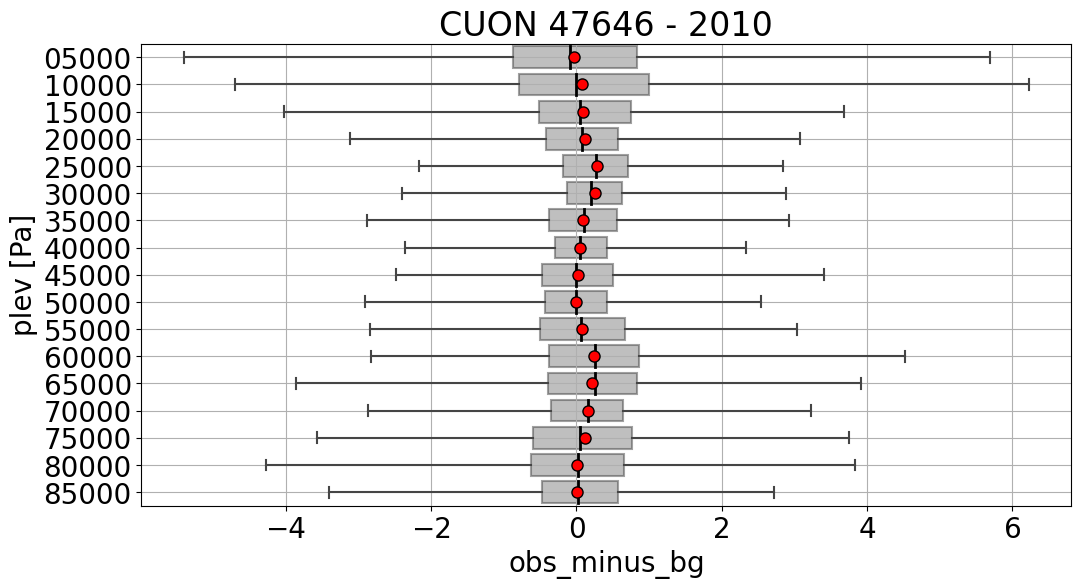

/tmp/ipykernel_3893468/1240916961.py:135: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_diff = df_in_2010.groupby('plev').mean() - df_in_2008.groupby('plev').mean()
/tmp/ipykernel_3893468/1240916961.py:135: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_diff = df_in_2010.groupby('plev').mean() - df_in_2008.groupby('plev').mean()


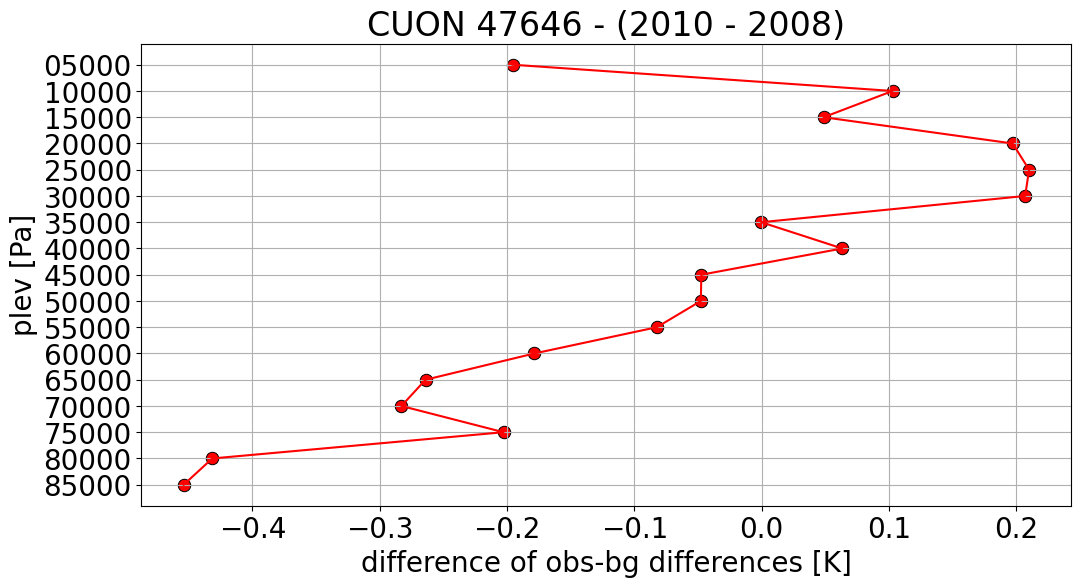

In [14]:
try:
    del dl
    del v_data
    del df_in
except:
    pass
rq = {
    "statid": "47646",
    "date": ["20080101-20081231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = dl.to_dataframe()
print(df_tateno.sonde_type.drop_duplicates())


out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_tateno.time.drop_duplicates():
    v_data = df_tateno[df_tateno.time == i]
    for plev in range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2008 = pd.DataFrame.from_dict(out)
df_in_2008.plev = df_in_2008.plev.str.zfill(5)

ax = seaborn.boxplot(
            data=df_in_2008,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47646 - 2008')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

try:
    del dl
    del v_data
    del df_in
except:
    pass

rq = {
    "statid": "47646",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = dl.to_dataframe()
print(df_compare.sonde_type.drop_duplicates())
out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    v_data = df_compare[df_compare.time == i]
    for plev in range(5000, 90000, 5000):
        diffs.append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)]
            .iloc[0]
            .obs_minus_bg
        )
        out["time"].append(
            v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
        )
        out["Difference"].append(diffs[-1])
        out["plev"].append(str(plev))

df_in_2010 = pd.DataFrame.from_dict(out)
df_in_2010.plev = df_in_2010.plev.str.zfill(5)


ax = seaborn.boxplot(
            data=df_in_2010,
            x='Difference',
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=False,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": 'grey', "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
ax.set_title('CUON 47646 - 2010')
ax.set(xlabel="obs_minus_bg", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

year_diff = df_in_2010.groupby('plev').mean() - df_in_2008.groupby('plev').mean()
year_diff = year_diff.sort_values('plev')
ax = seaborn.scatterplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            marker= "o",
            color = "red",
            edgecolor= 'black',
            s = 80,
        )
ax = seaborn.lineplot(
            x=year_diff['Difference'],
            y=year_diff.index,
            color = "red",
            sort=False,
        )
ax.set_title('CUON 47646 - (2010 - 2008)')
ax.set(xlabel="difference of obs-bg differences [K]", ylabel="plev [Pa]")
plt.grid()
plt.show()
plt.close()

In [18]:
# rq = {
#     "statid": "47646",
#     "date": ["20050101-20051231"],
#     "variable": ["air_temperature"],
#     "format": "nc",
#     "optional": ["sonde_type", "obs_minus_bg"],
# }
# dl = eua.vm_request_wrapper(rq, overwrite=True)
# df_tateno = dl.to_dataframe()
# print(df_tateno.sonde_type.drop_duplicates())

# rq = {
#     "statid": "47678",
#     "date": ["20050101-20051231"],
#     "variable": ["air_temperature"],
#     "format": "nc",
#     "optional": ["sonde_type", "obs_minus_bg"],
# }
# dl = eua.vm_request_wrapper(rq, overwrite=True)
# df_compare = dl.to_dataframe()
# print(df_compare.sonde_type.drop_duplicates())

# out = {"Difference": [], "plev": [], "time": []}
# diffs = []
# for i in df_compare.time.drop_duplicates():
#     # print(i.date())
#     meis_time = df_tateno[df_tateno.time.dt.date == i.date()]
#     for j in meis_time.report_id.drop_duplicates():
#         mt = meis_time[meis_time.report_id == j].time.iloc[0]
#         dh = float((i - mt) / np.timedelta64(1, "h"))
#         if np.logical_and(dh < 1, dh > -1):
#             # print(i, mt, "delta hours: ", dh)
#             # print(j)
#             # print()
#             m_data = df_tateno[df_tateno.report_id == j]
#             v_data = df_compare[df_compare.time == i]
#             for plev in range(5000, 90000, 5000):
#                 diffs.append(
#                     v_data[v_data.plev == find_nearest(v_data.plev, plev)]
#                     .iloc[0]
#                     .obs_minus_bg
#                     - m_data[m_data.plev == find_nearest(m_data.plev, plev)]
#                     .iloc[0]
#                     .obs_minus_bg
#                 )
#                 out["time"].append(
#                     v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
#                 )
#                 out["Difference"].append(diffs[-1])
#                 out["plev"].append(str(plev))

# df_in = pd.DataFrame.from_dict(out)
# to_df = {'plev':[], 'time':[], 'Difference':[]}

# for i in df_in[df_in.time.dt.hour == 0].time:
#     for j in df_in[df_in.time.dt.date == i.date()].plev.drop_duplicates():
#         try:
#             sel_df = (df_in[np.logical_and(df_in.time.dt.date == i.date(), df_in.plev == j)])
#             diff = sel_df[sel_df.time.dt.hour == 0].Difference.values - sel_df[sel_df.time.dt.hour == 12].Difference.values
#             to_df['Difference'].append(diff[0])
#             to_df['plev'].append(j)
#             to_df['time'].append(i)
#         except:
#             pass
# df_in = pd.DataFrame.from_dict(to_df)

# df_in.plev = df_in.plev.str.zfill(5)
# df_in = df_in.sort_values(by="plev")

# for i in zip(
#     [
#         "Difference",
#     ],
#     ["grey"],
# ):
#     q3, q1 = np.percentile(df_in[i[0]].dropna(), [75, 25])
#     iqr = q3 - q1
#     df_in[i[0]] = df_in[i[0]][
#         np.logical_and(df_in[i[0]] < 3 * iqr, df_in[i[0]] > -3 * iqr)
#     ]
#     ax = seaborn.boxplot(
#         data=df_in,
#         x=i[0],
#         y="plev",
#         notch=False,
#         showcaps=True,
#         # fliersize = 100,
#         showfliers=True,
#         dodge=False,
#         showmeans=True,
#         boxprops={"facecolor": i[1], "alpha": 0.5},
#         medianprops={
#             "color": i[1],
#             "linewidth": 2,
#         },
#         meanprops={
#             "marker": "o",
#             "markerfacecolor": "red",
#             "markeredgecolor": "black",
#             "markersize": "8",
#         },
#         whis=3,
#         # whis=1.5,
#     )
#     ax.set_title('Japan 2005 '+ 'Night - Day')
#     ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
#     plt.grid()
#     plt.show()
#     plt.close()

In [19]:
# ax = seaborn.histplot(df_diff, label='Vaisala - Meisei', kde=True)
# ax.set(xlabel="Adjustments")
# ax.set(title='temperature difference to Vaisala sonde')
# plt.legend()
# plt.show()

## 2010 intercomparison 

In [20]:
table = pd.read_csv('./table3685.csv')
interc = pd.read_csv('./wmo_intercomparison_2010.csv')

In [21]:
for i in interc.sonde_id.drop_duplicates():
    print(table[table.tac_code == i].description)

Series([], Name: description, dtype: object)
Series([], Name: description, dtype: object)
40    Graw DFM-06 (Germany)
Name: description, dtype: object
Series([], Name: description, dtype: object)
Series([], Name: description, dtype: object)
27    Sprenger E085 (Germany)                                                   
79    Vaisala RS41 with pressure derived from GPS height/DigiCORA MW41 (Finland)
Name: description, dtype: object
29    AIR IS - 4A - 1680 (United States)
81    NanJing Daqiao XGP-3G (China)*    
Name: description, dtype: object
85    Meisei RS2-91 (Japan)
Name: description, dtype: object
Series([], Name: description, dtype: object)
56    Vaisala RS80 /Autosonde (Finland)
Name: description, dtype: object
60    Sippican MARK II with chip thermistor, carbon element and derived pressure from GPS height
Name: description, dtype: object
11    Mesural FMO 1950A (France)          
45    Vaisala RS41/DigiCORA MW41 (Finland)
Name: description, dtype: object
12    Mesural FMO 194

In [22]:
len(interc.sonde_code.drop_duplicates()), len(interc.sonde_id.drop_duplicates()), len(interc.sonde_name.drop_duplicates())

(13, 15, 10)

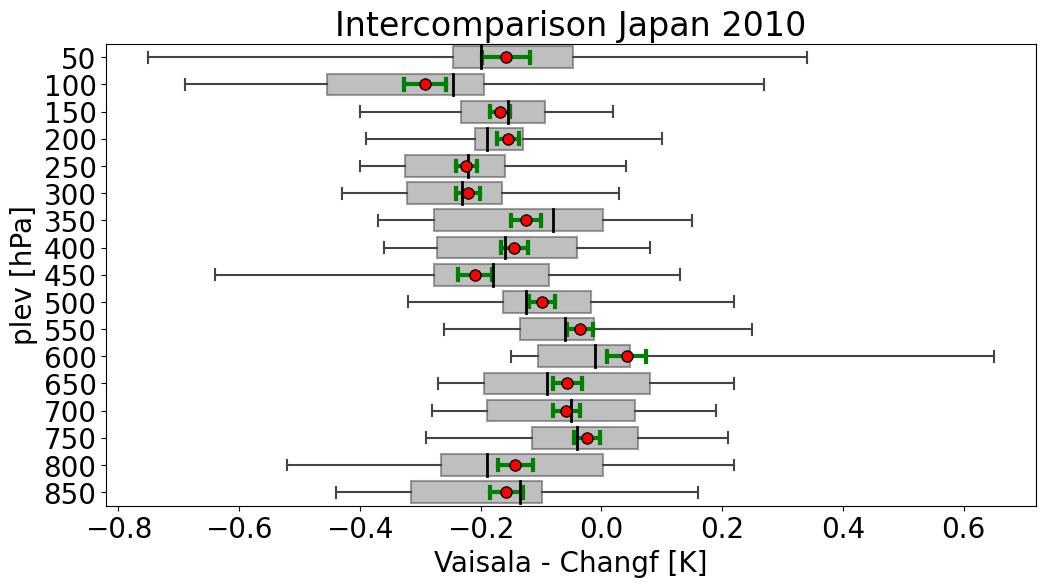

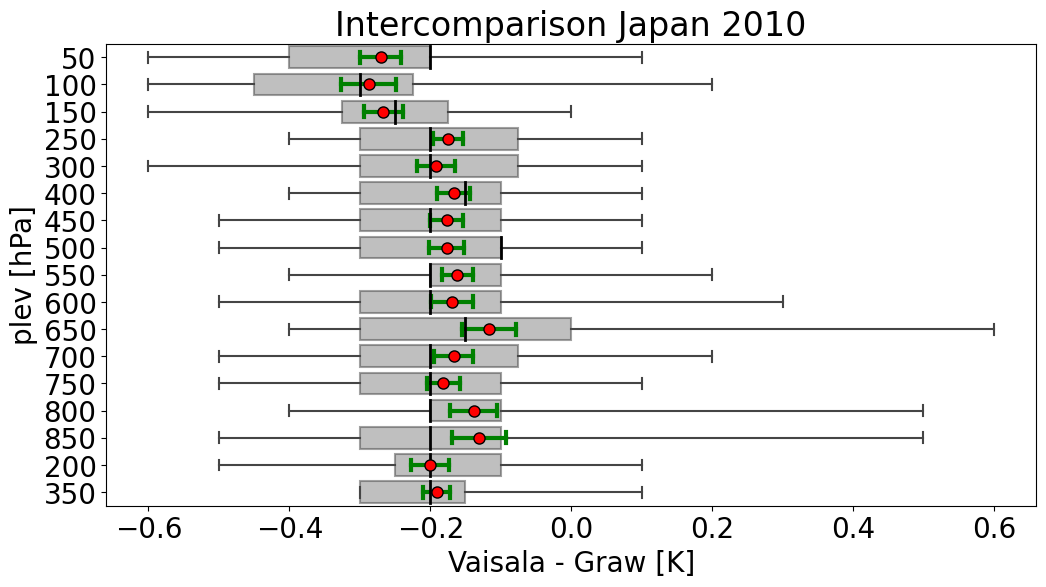

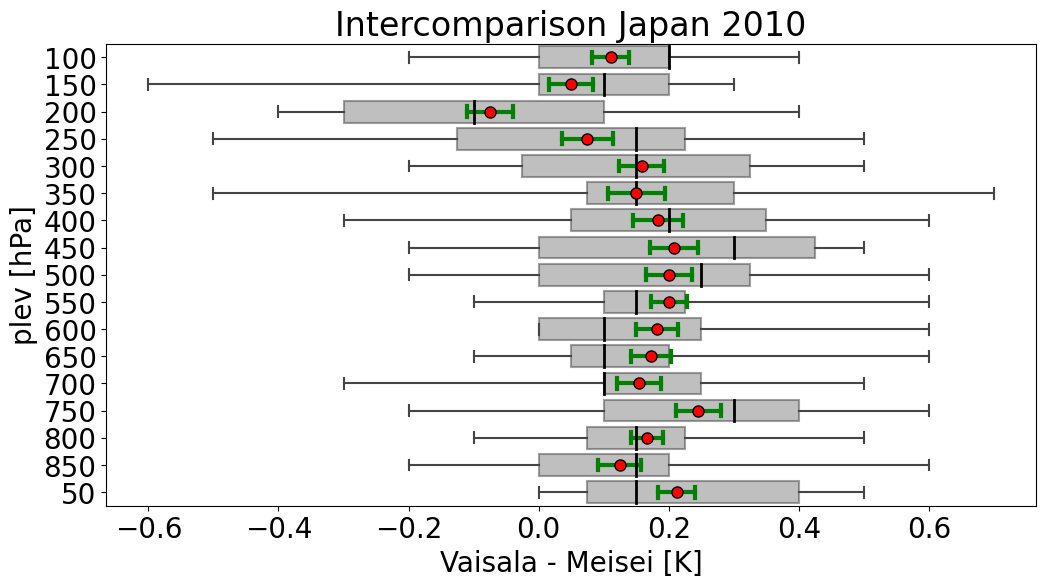

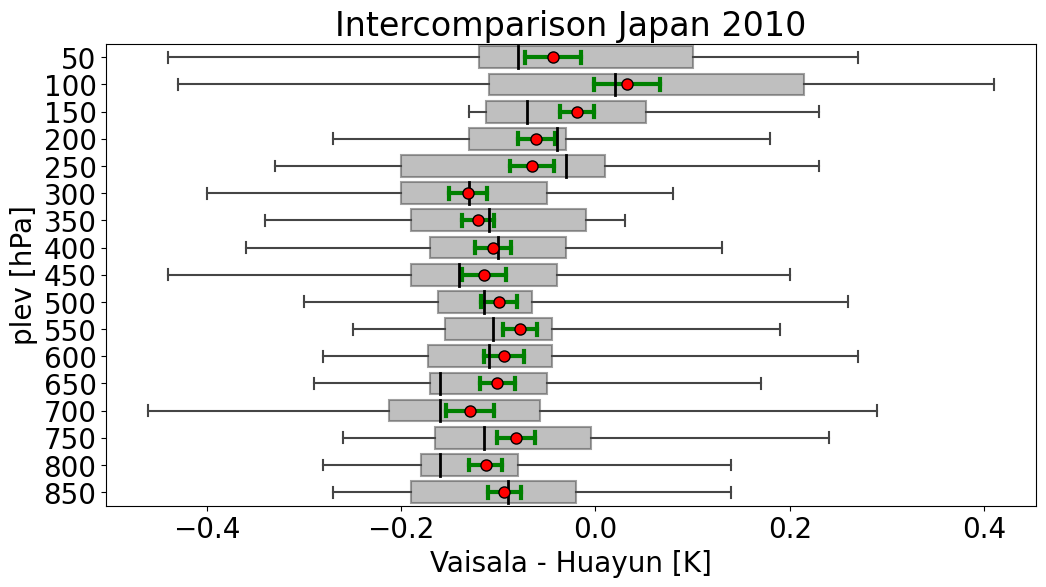

In [23]:
data_cleaned = {}
plevs = {}


for asc in np.sort(glob.glob('/users/staff/uvoggenberger/CEUAS/CEUAS/public/intercomparisons/DATA/Vaisala/*')):
    try:
        ascentnr = asc[-3:]
        for i in glob.glob('/users/staff/uvoggenberger/CEUAS/CEUAS/public/intercomparisons/DATA/*/*.'+ascentnr):
            text = open(i, "r", encoding= 'unicode_escape')
            # display(text)

            #join() method combines all contents of 
            # csvfile.csv and formed as a string
            text = ''.join([j for j in text]) 

            # search and replace the contents
            text = text.replace("\t", ",") 
            text = re.sub(" +", ",", text)
            # output.csv is the output file opened in write mode
            x = open('./'+i.split('/')[-1],"w")

            # all the replaced text is written in the output.csv file
            x.writelines(text)
            x.close()

        yang_dfs = []
        for i in glob.glob('./*.'+ascentnr):
            df = pd.read_csv(i, delimiter=',', header=0, encoding= 'unicode_escape')
            # print(i)
            yang_dfs.append(df)

        labels = glob.glob('./*.'+ascentnr)
        compare_to = labels.index([s for s in labels if "Vaisala" in s][0])
        # print(compare_to)

        yang_dfs[compare_to].Pressure = pd.to_numeric(yang_dfs[compare_to].Pressure, errors='coerce')
        yang_dfs[compare_to] = yang_dfs[compare_to].dropna(subset = ['Pressure'])
        yang_dfs[compare_to].Temperature = pd.to_numeric(yang_dfs[compare_to].Temperature, errors='coerce')
        yang_dfs[compare_to] = yang_dfs[compare_to].dropna(subset = ['Temperature'])
        
        for plev_to_check in range(50, 900, 50):
            cp_to = yang_dfs[compare_to][yang_dfs[compare_to].Pressure == find_nearest(yang_dfs[compare_to].Pressure, plev_to_check)]

            for sonde in range(len(labels)):
                label = labels[sonde][2:].split('.')[0]
                if sonde == compare_to:
                    continue

                yang_dfs[sonde].Pressure = pd.to_numeric(yang_dfs[sonde].Pressure, errors='coerce')
                yang_dfs[sonde] = yang_dfs[sonde].dropna(subset = ['Pressure'])
                yang_dfs[sonde].Temperature = pd.to_numeric(yang_dfs[sonde].Temperature, errors='coerce')
                yang_dfs[sonde] = yang_dfs[sonde].dropna(subset = ['Temperature'])

                for press in range(len(cp_to)):
                    delta_t = (
                        cp_to.Temperature.iloc[press]
                        - yang_dfs[sonde][
                            yang_dfs[sonde].Pressure
                            == find_nearest(
                                np.array(yang_dfs[sonde].Pressure),
                                cp_to.Pressure.iloc[press]
                            )
                        ].Temperature.values[0]
                    )
                if label in list(data_cleaned.keys()):
                    data_cleaned[label].append(delta_t)
                    plevs[label].append(str(plev_to_check))
                else:
                    data_cleaned[label]=[delta_t]
                    plevs[label]=[str(plev_to_check)]

    except:
        pass
        # print('error')
        
try: 
    labels.remove('./Vaisala.069')
except: 
    pass

for i in labels:
    label = i[2:].split(".")[0]
    data_cleaned[label] = np.array(data_cleaned[label])
    plevs[label] = np.array(plevs[label])
    q3, q1 = np.percentile(data_cleaned[label], [75 ,25])
    iqr = q3 - q1
    plevs[label] = plevs[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]
    data_cleaned[label] = data_cleaned[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]
    

    ax = seaborn.boxplot(
        x=data_cleaned[label],
        y=plevs[label],
        notch=False,
        showcaps=True,
        showfliers=True,
        dodge=False,
        boxprops={"facecolor": "grey", "alpha": 0.5},
        medianprops={"color": "black", "linewidth": 2},
        meanprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markeredgecolor": "black",
            "markersize": "8",
        },
        showmeans =  True, 
        whis=np.inf,
        # whis=1.5,
    ).set(xlabel='Vaisala - ' + label + ' [K]', ylabel="plev [hPa]")
    kwargs = {'alpha':0}
    ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.4, n_boot=len(data_cleaned[label]), errorbar=('sd',float(2/np.sqrt(len(data_cleaned[label])))), errwidth=3, errcolor='green', **kwargs)
    ax.set_title('Intercomparison Japan 2010')
    # ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
    # ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('pi',90), errwidth=3, **kwargs)

    plt.show()
    plt.close()

# Japan stations

JAM00047600  37.3914  136.8953    5.2 WAJIMA
JAM00047604  37.9170  139.0500    6.0 NIIGATA
JAM00047624  36.4000  139.0670  113.0 MAEBASHI
JAM00047646  36.0581  140.1258   25.2 TATENO
JAM00047655  34.6000  138.2170   47.0 OMAEZAKI
JAM00047678  33.1217  139.7792  151.2 HACHIJOJIMA
JAM00047681  34.7503  137.7030   45.7    HAMAMATSU AB
JAM00047684  34.9330  136.5830   56.0 YOKKAICHI
JAM00047688  34.9830  139.8330    6.0    TATEYAMA AB
JAM00047696  35.2800  139.6700   49.0 YOKOSUKA

In [24]:
coords = [[37.3914, 136.8953, 47600], [37.9170, 139.0500, 47604], [36.4000, 139.0670, 47624], [36.0581, 140.1258, 47646], [34.6000, 138.2170, 47655], 
          [33.1217, 139.7792, 47678], [34.7503, 137.7030, 47681], [34.9330, 136.5830, 47684], [34.9830, 139.8330, 47688], [35.2800, 139.6700, 47696]]

In [25]:
dist = []
target = [33.1217, 139.7792]
for i in coords:
    dist.append((i[2],np.abs(target[0] - i[0]) + np.abs(target[1] - i[1])))
dist

[(47600, 7.1536000000000115),
 (47604, 5.524499999999996),
 (47624, 3.9904999999999973),
 (47646, 3.2830000000000013),
 (47655, 3.0404999999999944),
 (47678, 0.0),
 (47681, 3.704800000000006),
 (47684, 5.007500000000007),
 (47688, 1.9150999999999954),
 (47696, 2.2675000000000196)]

In [26]:
for i in coords:
    if i[2] != 47646:
        try:
            rq = {
                "statid": str(i[2]),

                "date": ["20100101-20101231"],
                "variable": ["air_temperature"],
                "format": "nc",
                "optional": ['sonde_type', 'obs_minus_bg'],
            }
            dl = eua.vm_request_wrapper(rq, overwrite=True)
            df_compare = dl.to_dataframe()
            print(i[2])
            # display(df_compare)
        except:
            print(i[2], 'no data')

47600
47604 no data
47624 no data
47655 no data
47678
47681
47684 no data
47688 no data
47696 no data


##  568 :   J9H  :  J9H Japan Meisei RSII-91 radiosonde, RH correction {200302} 31313=74702^ (W3=47) <F=T1680FL,P=Ac,T=TR,U=A>


 ## 2639 :   VN8  :  VN8 Vaisala RS92 Autosonde auto corr, GPS wind 31313=48108^ <F=T400-406DL,P=Sc,T=Wc,U=2Ah,N=G>


## 310 km distance HACHIJOJIMA Island to TATENO 
## 2010

0    J9H 
Name: sonde_type, dtype: object
0    VN8 
Name: sonde_type, dtype: object


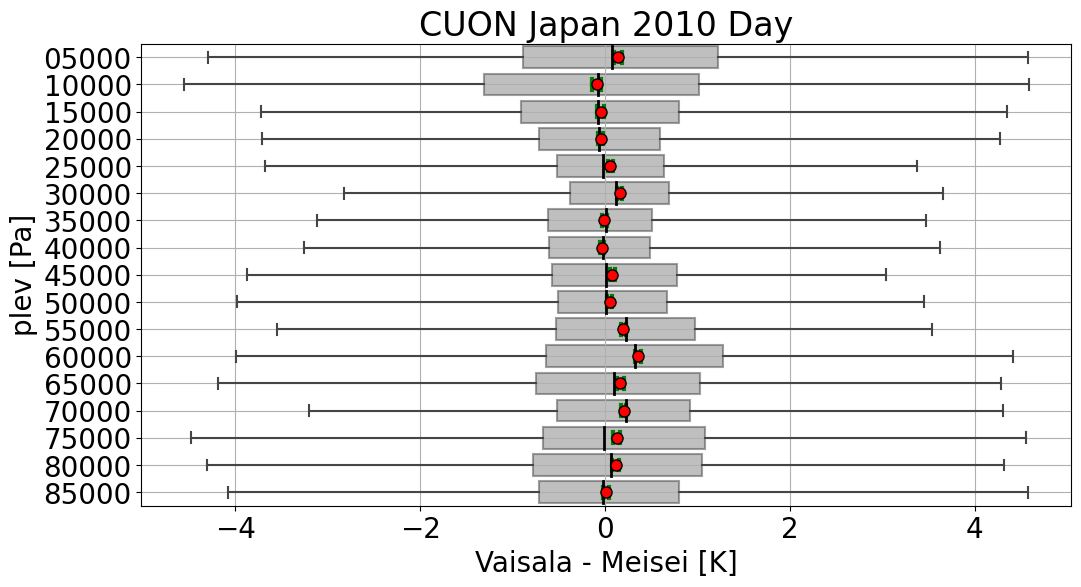

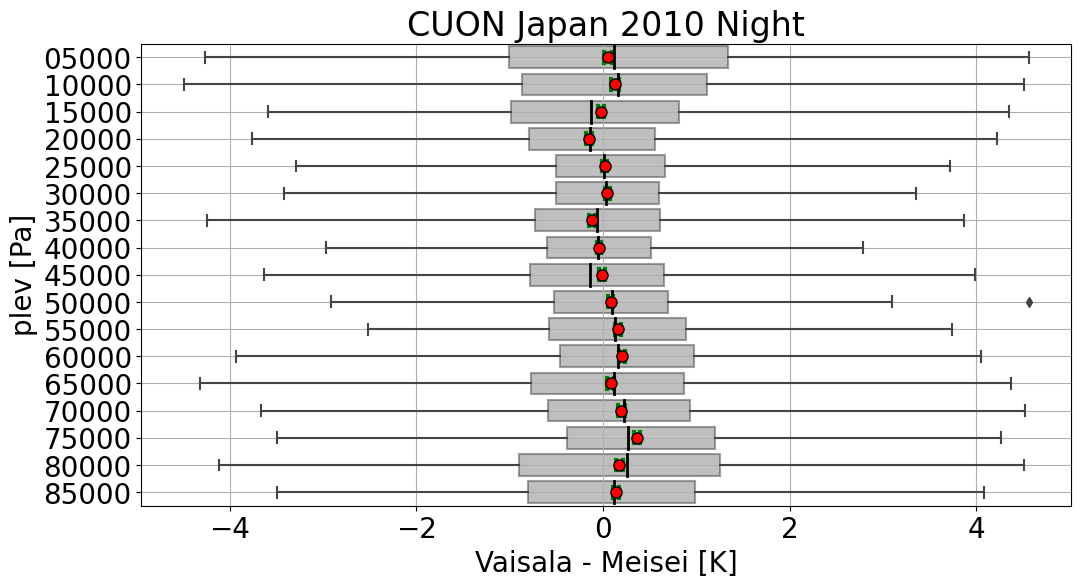

In [27]:
rq = {
    "statid": "47646",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = dl.to_dataframe()
print(df_compare.sonde_type.drop_duplicates())

rq = {
    "statid": "47678",
    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = dl.to_dataframe()
print(df_tateno.sonde_type.drop_duplicates())

out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    # print(i.date())
    meis_time = df_tateno[df_tateno.time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].time.iloc[0]
        dh = float((i - mt) / np.timedelta64(1, "h"))
        if np.logical_and(dh < 1, dh > -1):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_tateno[df_tateno.report_id == j]
            v_data = df_compare[df_compare.time == i]
            for plev in range(5000, 90000, 5000):
                diffs.append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                    - m_data[m_data.plev == find_nearest(m_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                )
                out["time"].append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
                )
                out["Difference"].append(diffs[-1])
                out["plev"].append(str(plev))

for tm in ["Day", "Night"]:
    df_in = pd.DataFrame.from_dict(out)
    if tm == "Day":
        df_in = df_in[np.logical_and(df_in.time.dt.hour > 6, df_in.time.dt.hour <= 18)]
    else:
        df_in = df_in[np.logical_or(df_in.time.dt.hour <= 6, df_in.time.dt.hour > 18)]
    df_in.plev = df_in.plev.str.zfill(5)
    df_in = df_in.sort_values(by="plev")

    for i in zip(
        [
            "Difference",
        ],
        ["grey"],
    ):
        q3, q1 = np.percentile(df_in[i[0]].dropna(), [75, 25])
        iqr = q3 - q1
        df_in[i[0]] = df_in[i[0]][
            np.logical_and(df_in[i[0]] < 3 * iqr, df_in[i[0]] > -3 * iqr)
        ]
        ax = seaborn.boxplot(
            data=df_in,
            x=i[0],
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=True,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": i[1], "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
        kwargs = {'alpha':0}
        ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.4, n_boot=len(df_in[i[0]]), errorbar=('sd',float(2/np.sqrt(len(df_in[i[0]])))), errwidth=3, errcolor='green', **kwargs)
        # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
        ax.set_title('CUON Japan 2010 '+ tm)
        ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
        plt.grid()
        plt.show()
        plt.close()

## Intercomparison 2010

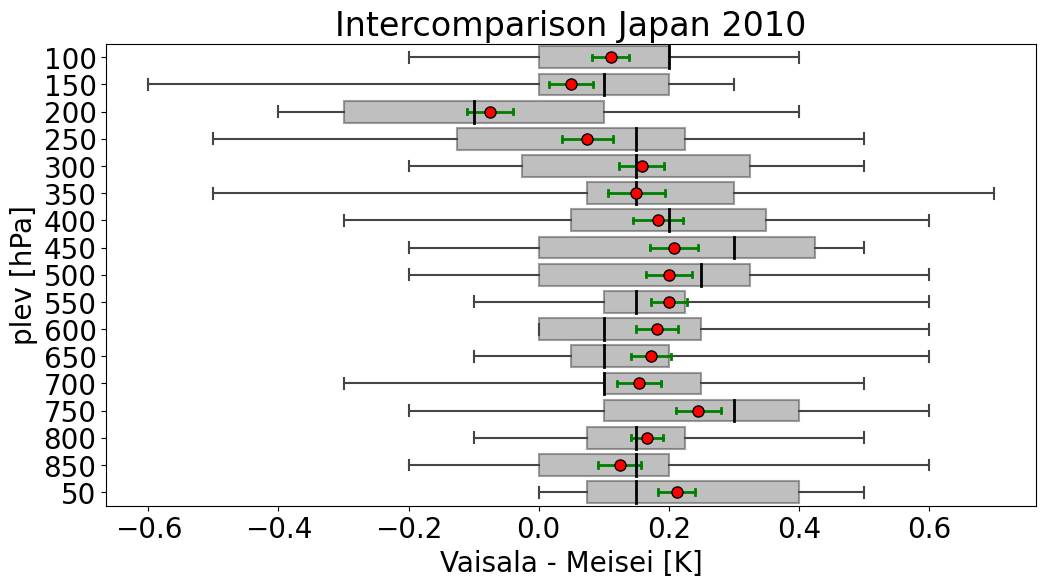

In [28]:
i = labels[2]
label = i[2:].split(".")[0]
data_cleaned[label] = np.array(data_cleaned[label])
plevs[label] = np.array(plevs[label])
q3, q1 = np.percentile(data_cleaned[label], [75 ,25])
iqr = q3 - q1
plevs[label] = plevs[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]
data_cleaned[label] = data_cleaned[label][np.logical_and(data_cleaned[label] < 3*iqr, data_cleaned[label] > -3*iqr)]


ax = seaborn.boxplot(
    x=data_cleaned[label],
    y=plevs[label],
    notch=False,
    showcaps=True,
    showfliers=True,
    dodge=False,
    boxprops={"facecolor": "grey", "alpha": 0.5},
    medianprops={"color": "black", "linewidth": 2},
    meanprops={
        "marker": "o",
        "markerfacecolor": "red",
        "markeredgecolor": "black",
        "markersize": "8",
    },
    showmeans =  True, 
    whis=np.inf,
    # whis=1.5,
).set(xlabel='Vaisala - ' + label + ' [K]', ylabel="plev [hPa]")
kwargs = {'alpha':0}
ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('sd',float(2/np.sqrt(len(data_cleaned[label])))), errwidth=2, errcolor='green', **kwargs)
ax.set_title('Intercomparison Japan 2010')
# ax = seaborn.barplot(x=data_cleaned[label], y=plevs[label], capsize=.2, n_boot=len(data_cleaned[label]), errorbar=('ci'), errwidth=3, errcolor='blue', **kwargs)
plt.show()
plt.close()

## 2008

0    J9H 
Name: sonde_type, dtype: object
0    VN8 
Name: sonde_type, dtype: object


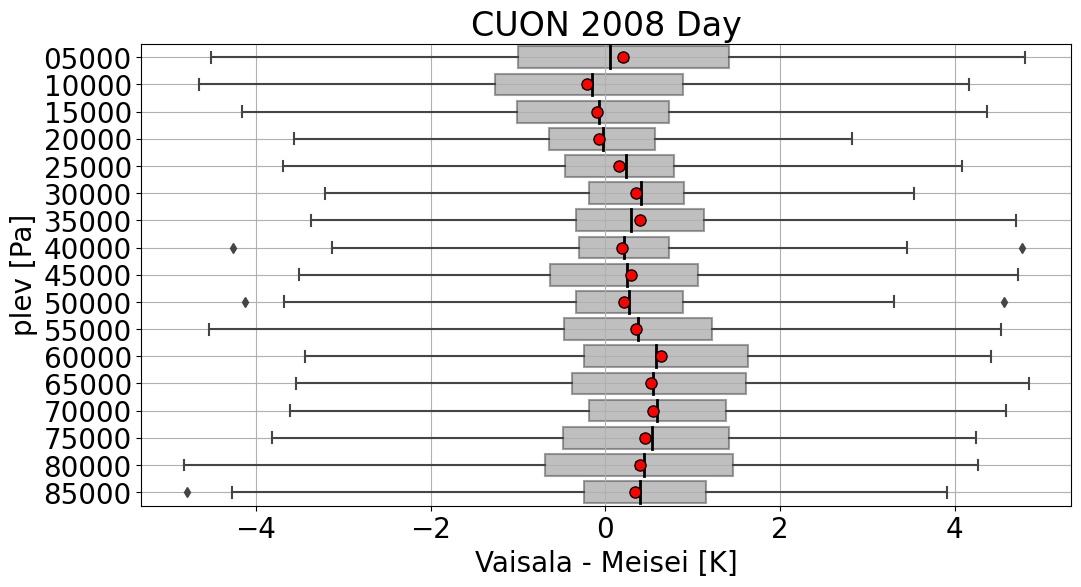

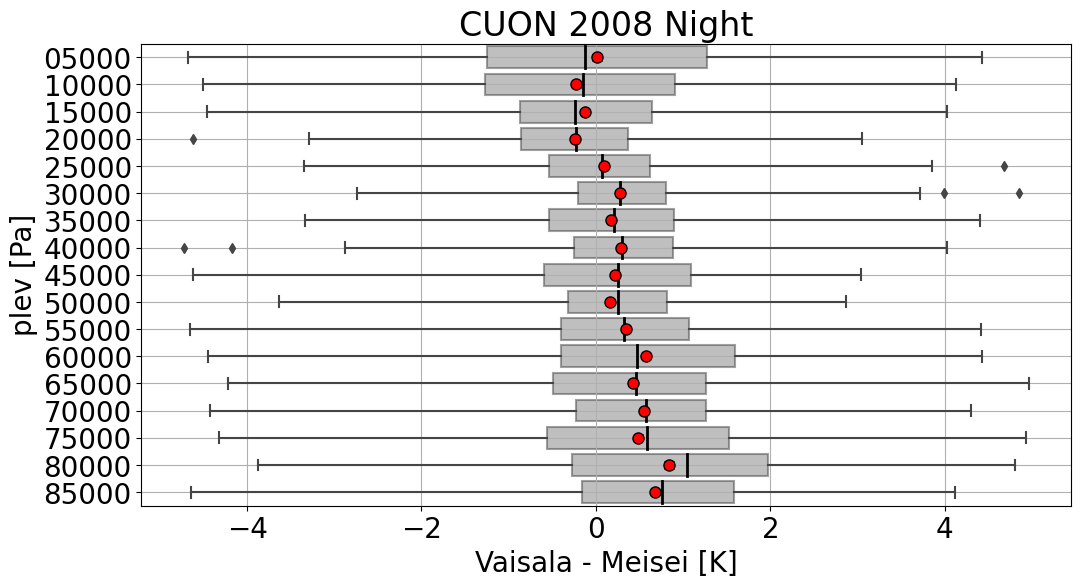

In [29]:
rq = {
    "statid": "47646",
    "date": ["20080101-20081231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_compare = dl.to_dataframe()
print(df_compare.sonde_type.drop_duplicates())




rq = {
    "statid": "47678",
    "date": ["20080101-20081231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ["sonde_type", "obs_minus_bg"],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
df_tateno = dl.to_dataframe()
print(df_tateno.sonde_type.drop_duplicates())

out = {"Difference": [], "plev": [], "time": []}
diffs = []
for i in df_compare.time.drop_duplicates():
    # print(i.date())
    meis_time = df_tateno[df_tateno.time.dt.date == i.date()]
    for j in meis_time.report_id.drop_duplicates():
        mt = meis_time[meis_time.report_id == j].time.iloc[0]
        dh = float((i - mt) / np.timedelta64(1, "h"))
        if np.logical_and(dh < 1, dh > -1):
            # print(i, mt, "delta hours: ", dh)
            # print(j)
            # print()
            m_data = df_tateno[df_tateno.report_id == j]
            v_data = df_compare[df_compare.time == i]
            for plev in range(5000, 90000, 5000):
                diffs.append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                    - m_data[m_data.plev == find_nearest(m_data.plev, plev)]
                    .iloc[0]
                    .obs_minus_bg
                )
                out["time"].append(
                    v_data[v_data.plev == find_nearest(v_data.plev, plev)].iloc[0].time
                )
                out["Difference"].append(diffs[-1])
                out["plev"].append(str(plev))

for tm in ["Day", "Night"]:
    df_in = pd.DataFrame.from_dict(out)
    if tm == "Day":
        df_in = df_in[np.logical_and(df_in.time.dt.hour > 6, df_in.time.dt.hour <= 18)]
    else:
        df_in = df_in[np.logical_or(df_in.time.dt.hour <= 6, df_in.time.dt.hour > 18)]
    df_in.plev = df_in.plev.str.zfill(5)
    df_in = df_in.sort_values(by="plev")

    for i in zip(
        [
            "Difference",
        ],
        ["grey"],
    ):
        q3, q1 = np.percentile(df_in[i[0]].dropna(), [75, 25])
        iqr = q3 - q1
        df_in[i[0]] = df_in[i[0]][
            np.logical_and(df_in[i[0]] < 3 * iqr, df_in[i[0]] > -3 * iqr)
        ]
        ax = seaborn.boxplot(
            data=df_in,
            x=i[0],
            y="plev",
            notch=False,
            showcaps=True,
            # fliersize = 100,
            showfliers=True,
            dodge=False,
            showmeans=True,
            boxprops={"facecolor": i[1], "alpha": 0.5},
            medianprops={
                "color": 'black',
                "linewidth": 2,
            },
            meanprops={
                "marker": "o",
                "markerfacecolor": "red",
                "markeredgecolor": "black",
                "markersize": "8",
            },
            whis=3,
            # whis=1.5,
        )
        kwargs = {'alpha':0}
        ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('sd',float(2/np.sqrt(len(df_in[i[0]])))), errwidth=2, errcolor='green', **kwargs)
        # ax = seaborn.barplot(data=df_in, x=i[0], y="plev", capsize=.2, n_boot=len(df_in[i[0]]), errorbar=('ci',95), errwidth=3, errcolor='blue', **kwargs)
        ax.set_title('CUON 2008 '+ tm)
        ax.set(xlabel="Vaisala - Meisei [K]", ylabel="plev [Pa]")
        plt.grid()
        plt.show()
        plt.close()

## South Korea

47261:  34.5541: 126.5694:  14:V9U:200101000000:+<:Haenam Reference Site, South Korea
47102:  37.9675: 124.6303: 162:V9-:200009281200:*+:Baengyeong Do, South Korea
47169:  34.68: 125.45:  83:VNg:200804010600:*+:Heuksan Do, South Korea 

In [33]:
for i in [47261, 47102, 47169]:
    try:
        rq = {
            "statid": str(i),

            "date": ["20100101-20101231"],
            "variable": ["air_temperature"],
            "format": "nc",
            "optional": ['sonde_type',],
        }
        dl = eua.vm_request_wrapper(rq, overwrite=True)
        df_compare = dl.to_dataframe()
        print(i)
        display(df_compare[:10])
    except:
        print(i, 'no data')

47261 no data
47102


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,37.970001,124.629997,0,3520.0,100000000014674,V9-,0-20000-0-47102,220.899994,2010-01-01
1,37.970001,124.629997,0,3580.0,100000000014674,V9-,0-20000-0-47102,221.100006,2010-01-01
2,37.970001,124.629997,0,3860.0,100000000014674,V9-,0-20000-0-47102,216.300003,2010-01-01
3,37.970001,124.629997,0,4030.0,100000000014674,V9-,0-20000-0-47102,217.899994,2010-01-01
4,37.970001,124.629997,0,4080.0,100000000014674,V9-,0-20000-0-47102,214.500000,2010-01-01
5,37.970001,124.629997,0,4300.0,100000000014674,V9-,0-20000-0-47102,214.899994,2010-01-01
6,37.970001,124.629997,0,5000.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01
7,37.970001,124.629997,0,5010.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01
8,37.970001,124.629997,0,5230.0,100000000014674,V9-,0-20000-0-47102,214.500000,2010-01-01
9,37.970001,124.629997,0,6200.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01


47169


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,34.68,125.449997,0,820.0,100000000004835,VNg,0-20000-0-47169,228.100006,2010-01-01
1,34.68,125.449997,0,1000.0,100000000004835,VNg,0-20000-0-47169,226.300003,2010-01-01
2,34.68,125.449997,0,1400.0,100000000004835,VNg,0-20000-0-47169,219.699997,2010-01-01
3,34.68,125.449997,0,1750.0,100000000004835,VNg,0-20000-0-47169,223.699997,2010-01-01
4,34.68,125.449997,0,2000.0,100000000004835,VNg,0-20000-0-47169,220.500000,2010-01-01
5,34.68,125.449997,0,2420.0,100000000004835,VNg,0-20000-0-47169,218.100006,2010-01-01
6,34.68,125.449997,0,3000.0,100000000004835,VNg,0-20000-0-47169,218.500000,2010-01-01
7,34.68,125.449997,0,3050.0,100000000004835,VNg,0-20000-0-47169,217.899994,2010-01-01
8,34.68,125.449997,0,3350.0,100000000004835,VNg,0-20000-0-47169,220.300003,2010-01-01
9,34.68,125.449997,0,3630.0,100000000004835,VNg,0-20000-0-47169,214.500000,2010-01-01


## Korea stations
### only contain Vaisala or VIZ sondes

In [34]:
rq = {
    "country": 'KOR',

    "date": ["20100101-20101231"],
    "variable": ["air_temperature"],
    "format": "nc",
    "optional": ['sonde_type',],
}
dl = eua.vm_request_wrapper(rq, overwrite=True)
for i in dl:
    display(dl[i].to_dataframe()[:10])


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,38.25,128.570007,0,8130.0,100000000012621,VNg,0-20000-0-47090,219.500000,2010-01-01
1,38.25,128.570007,0,10000.0,100000000012621,VNg,0-20000-0-47090,215.899994,2010-01-01
2,38.25,128.570007,0,15000.0,100000000012621,VNg,0-20000-0-47090,220.699997,2010-01-01
3,38.25,128.570007,0,16700.0,100000000012621,VNg,0-20000-0-47090,223.500000,2010-01-01
4,38.25,128.570007,0,20000.0,100000000012621,VNg,0-20000-0-47090,223.100006,2010-01-01
5,38.25,128.570007,0,24700.0,100000000012621,VNg,0-20000-0-47090,225.300003,2010-01-01
6,38.25,128.570007,0,25000.0,100000000012621,VNg,0-20000-0-47090,224.300003,2010-01-01
7,38.25,128.570007,0,26300.0,100000000012621,VNg,0-20000-0-47090,219.500000,2010-01-01
8,38.25,128.570007,0,28900.0,100000000012621,VNg,0-20000-0-47090,220.699997,2010-01-01
9,38.25,128.570007,0,30000.0,100000000012621,VNg,0-20000-0-47090,221.699997,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,37.970001,124.629997,0,3520.0,100000000014674,V9-,0-20000-0-47102,220.899994,2010-01-01
1,37.970001,124.629997,0,3580.0,100000000014674,V9-,0-20000-0-47102,221.100006,2010-01-01
2,37.970001,124.629997,0,3860.0,100000000014674,V9-,0-20000-0-47102,216.300003,2010-01-01
3,37.970001,124.629997,0,4030.0,100000000014674,V9-,0-20000-0-47102,217.899994,2010-01-01
4,37.970001,124.629997,0,4080.0,100000000014674,V9-,0-20000-0-47102,214.500000,2010-01-01
5,37.970001,124.629997,0,4300.0,100000000014674,V9-,0-20000-0-47102,214.899994,2010-01-01
6,37.970001,124.629997,0,5000.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01
7,37.970001,124.629997,0,5010.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01
8,37.970001,124.629997,0,5230.0,100000000014674,V9-,0-20000-0-47102,214.500000,2010-01-01
9,37.970001,124.629997,0,6200.0,100000000014674,V9-,0-20000-0-47102,218.699997,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,37.099998,127.029999,0,650.0,100000000075759,???,0-20000-0-47122,234.500000,2010-01-01
1,37.099998,127.029999,0,730.0,100000000075759,???,0-20000-0-47122,233.300003,2010-01-01
2,37.099998,127.029999,0,1000.0,100000000075759,???,0-20000-0-47122,229.100006,2010-01-01
3,37.099998,127.029999,0,1390.0,100000000075759,???,0-20000-0-47122,224.300003,2010-01-01
4,37.099998,127.029999,0,1610.0,100000000075759,???,0-20000-0-47122,226.500000,2010-01-01
5,37.099998,127.029999,0,1690.0,100000000075759,???,0-20000-0-47122,223.899994,2010-01-01
6,37.099998,127.029999,0,2000.0,100000000075759,???,0-20000-0-47122,225.100006,2010-01-01
7,37.099998,127.029999,0,2010.0,100000000075759,???,0-20000-0-47122,225.500000,2010-01-01
8,37.099998,127.029999,0,2170.0,100000000075759,???,0-20000-0-47122,222.500000,2010-01-01
9,37.099998,127.029999,0,3000.0,100000000075759,???,0-20000-0-47122,222.300003,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,36.029999,129.380005,0,640.0,100000000031856,C9,0-20000-0-47138,229.300003,2010-01-01
1,36.029999,129.380005,0,1000.0,100000000031856,C9,0-20000-0-47138,225.500000,2010-01-01
2,36.029999,129.380005,0,1490.0,100000000031856,C9,0-20000-0-47138,221.899994,2010-01-01
3,36.029999,129.380005,0,1580.0,100000000031856,C9,0-20000-0-47138,222.699997,2010-01-01
4,36.029999,129.380005,0,1710.0,100000000031856,C9,0-20000-0-47138,219.699997,2010-01-01
5,36.029999,129.380005,0,1970.0,100000000031856,C9,0-20000-0-47138,221.500000,2010-01-01
6,36.029999,129.380005,0,2000.0,100000000031856,C9,0-20000-0-47138,221.100006,2010-01-01
7,36.029999,129.380005,0,2200.0,100000000031856,C9,0-20000-0-47138,217.500000,2010-01-01
8,36.029999,129.380005,0,2430.0,100000000031856,C9,0-20000-0-47138,219.699997,2010-01-01
9,36.029999,129.380005,0,2620.0,100000000031856,C9,0-20000-0-47138,216.699997,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,35.119999,126.82,0,2360.0,100000000035165,Z4a,0-20000-0-47158,220.899994,2010-01-01
1,35.119999,126.82,0,3000.0,100000000035165,Z4a,0-20000-0-47158,222.100006,2010-01-01
2,35.119999,126.82,0,3140.0,100000000035165,Z4a,0-20000-0-47158,221.899994,2010-01-01
3,35.119999,126.82,0,4150.0,100000000035165,Z4a,0-20000-0-47158,209.100006,2010-01-01
4,35.119999,126.82,0,4930.0,100000000035165,Z4a,0-20000-0-47158,215.300003,2010-01-01
5,35.119999,126.82,0,5000.0,100000000035165,Z4a,0-20000-0-47158,215.300003,2010-01-01
6,35.119999,126.82,0,6960.0,100000000035165,Z4a,0-20000-0-47158,214.899994,2010-01-01
7,35.119999,126.82,0,7000.0,100000000035165,Z4a,0-20000-0-47158,214.699997,2010-01-01
8,35.119999,126.82,0,9920.0,100000000035165,Z4a,0-20000-0-47158,209.899994,2010-01-01
9,35.119999,126.82,0,10000.0,100000000035165,Z4a,0-20000-0-47158,209.899994,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,34.68,125.449997,0,820.0,100000000004835,VNg,0-20000-0-47169,228.100006,2010-01-01
1,34.68,125.449997,0,1000.0,100000000004835,VNg,0-20000-0-47169,226.300003,2010-01-01
2,34.68,125.449997,0,1400.0,100000000004835,VNg,0-20000-0-47169,219.699997,2010-01-01
3,34.68,125.449997,0,1750.0,100000000004835,VNg,0-20000-0-47169,223.699997,2010-01-01
4,34.68,125.449997,0,2000.0,100000000004835,VNg,0-20000-0-47169,220.500000,2010-01-01
5,34.68,125.449997,0,2420.0,100000000004835,VNg,0-20000-0-47169,218.100006,2010-01-01
6,34.68,125.449997,0,3000.0,100000000004835,VNg,0-20000-0-47169,218.500000,2010-01-01
7,34.68,125.449997,0,3050.0,100000000004835,VNg,0-20000-0-47169,217.899994,2010-01-01
8,34.68,125.449997,0,3350.0,100000000004835,VNg,0-20000-0-47169,220.300003,2010-01-01
9,34.68,125.449997,0,3630.0,100000000004835,VNg,0-20000-0-47169,214.500000,2010-01-01


,lat,lon,obs,plev,report_id,sonde_type,station_id,ta,time
0,33.279999,126.169998,0,790.0,100000000043569,C9,0-20000-0-47185,227.300003,2010-01-01
1,33.279999,126.169998,0,1000.0,100000000043569,C9,0-20000-0-47185,225.500000,2010-01-01
2,33.279999,126.169998,0,1350.0,100000000043569,C9,0-20000-0-47185,221.500000,2010-01-01
3,33.279999,126.169998,0,1620.0,100000000043569,C9,0-20000-0-47185,222.699997,2010-01-01
4,33.279999,126.169998,0,2000.0,100000000043569,C9,0-20000-0-47185,221.300003,2010-01-01
5,33.279999,126.169998,0,2120.0,100000000043569,C9,0-20000-0-47185,221.500000,2010-01-01
6,33.279999,126.169998,0,2270.0,100000000043569,C9,0-20000-0-47185,216.899994,2010-01-01
7,33.279999,126.169998,0,2500.0,100000000043569,C9,0-20000-0-47185,216.100006,2010-01-01
8,33.279999,126.169998,0,2830.0,100000000043569,C9,0-20000-0-47185,220.300003,2010-01-01
9,33.279999,126.169998,0,3000.0,100000000043569,C9,0-20000-0-47185,218.100006,2010-01-01
